# Error analysis notebook (test data)

## Import packages

In [2]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json


# theta 0.9, meta

## Set filepaths

In [3]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_9_1_train.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_hlevel.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_level.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
est_rel_meta_p = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
annotations = '../pre_pre_processing/resources/merged-annotations.json'
mapping = '../reranking/resources/mappings/training_doc_to_author.json'

## Prepare dataframes

In [4]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')


# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_p)
est_rel_meta.head()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# doc to author and reverse mapping
with open(mapping) as fp:
    doc_to_author = json.load(fp)
alldocs = rdf.explode('ranking')['ranking'].drop_duplicates().to_list()
for doc in alldocs:
    if not doc in doc_to_author:
        doc_to_author[doc] = []
    
author_to_doc = {}
for doc, aulist in doc_to_author.items():
    for au in aulist:
        if not au in author_to_doc:
            author_to_doc[au] = []
        author_to_doc[au] = author_to_doc[au] + [doc]

In [5]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."
1,0.1,5438,"[70f3a58b0fc6916c2e6616bfbae5758c00408894, ec1..."


In [6]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,5438,cloud computing,0.000057,{'doc_id': '3e19046c665867bbe557685da60738a407...,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,0.000057,{'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [7]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,5438,cloud computing,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [8]:
ehldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.146308,2.820826,2.254359
258,0.549351,1.043557,0.679082


In [9]:
eldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.211649,3.322678,2.491326
258,0.479589,2.230424,1.349051


In [10]:
adf.head(2)

,id,missing_authors,authors,name,wiki,country,type,valid,auth_id,h_index,level,region
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David M. Szymanski', 'wiki': 'Texas ...",David M. Szymanski,Texas A&M University,US,academic,True,50215565.0,9.0,Advanced,Americas
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David H. Henard', 'wiki': 'North Car...",David H. Henard,North Carolina State University,US,academic,True,115002169.0,8.0,Advanced,Americas


## Extract information for specific query

Helper methods.

In [11]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [12]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


## Error analysis template
For each ranker and grouping, we answer the following questions to gain insight into the points of failure of the ranker.

1. How often were top positions occupied by relevant documents? Can these documents be categorized and distinguished from other documents?
2. How often were top positions occupied by non-relevant documents? Can these documents be categorized and distinguished from other documents?
3. Which relevant documents appear rarely or not at all in the top positions? Why did these documents not appear in the top positions more often?
4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty?
5. What obvious mistakes did the system make that it could have easily avoided?
7. Other features of note  
    a. Number of top positions for this query.
8. What should the system do to improve performance?
9. What added information would be helpful? How can the system get that information?
10. Are there differences between the NIST assessment of documents and your own assessment?

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. The metric for our system is Difference in Group Expected Exposure (DGEE). We look at which queries are the easiest and most difficult for this ranker by ordering the queries by increasing DGEE. A point of interest here is that DGEE depends on the chosen grouping. Therefore, we look at the ordering for two different groupings, and then see if they agree with each other/take the average of the two orderings.

In [13]:
print("hlevel: ", ehldf.difference.mean(), "\tlevel: ", eldf.difference.mean())

hlevel:  0.43443999 	level:  0.42675122000000004


In [14]:
print("# docs with DGEE below/above mean")
print("hlevel\t<: ", len(ehldf[ehldf.difference > ehldf.difference.mean()]), "\t >: ", len(ehldf[ehldf.difference <= ehldf.difference.mean()]))
print("level\t<: ", len(eldf[eldf.difference > eldf.difference.mean()]), "\t >: ", len(eldf[eldf.difference <= eldf.difference.mean()]))

# docs with DGEE below/above mean
hlevel	<:  65 	 >:  135
level	<:  60 	 >:  140


The worst ten queries are:

In [15]:
worstquerieshl = ehldf.sort_values(by='difference',ascending=False).head(10)
worstqueriesl = eldf.sort_values(by='difference',ascending=False).head(10)

In [16]:
worstquerieshl

key,difference,disparity,relevance
qid,,,
111469,2.834201,2.170455,0.463842
31412,2.778232,2.016028,0.413475
33337,2.726048,2.320659,0.603397
47984,2.577560,2.464784,0.344646
5762,2.339087,1.462709,0.352224
11856,1.930131,1.856165,0.371319
125125,1.687319,1.136316,0.509687
84087,1.513666,1.270282,0.696999
76875,1.464672,1.654475,0.507753


The best ten queries are:

In [20]:
bestquerieshl = ehldf.sort_values(by='difference',ascending=True).head(10)
bestqueriesl = eldf.sort_values(by='difference',ascending=True).head(10)

In [21]:
bestquerieshl

key,difference,disparity,relevance
qid,,,
132049,0.002713,1.421254,1.403715
71096,0.029287,1.975807,1.862498
21984,0.032334,1.367385,1.271935
15395,0.040510,2.053024,1.890567
52728,0.057478,1.047360,0.839632
35778,0.063421,2.324523,2.033133
96265,0.068044,1.389924,1.122292
5667,0.068762,1.593546,1.318426
46183,0.076931,1.775022,1.730961


In [22]:
bestqueriesl

key,difference,disparity,relevance
qid,,,
132049,0.002713,1.421254,1.403715
71096,0.026328,1.972820,1.862484
15395,0.026948,2.035232,1.888323
68960,0.055780,1.806684,1.757368
129480,0.062249,1.349351,1.105418
54538,0.067307,1.435857,1.134208
21984,0.071535,1.515766,1.326630
77011,0.074452,1.456289,1.180714
36824,0.078852,2.012095,1.869204


We order the queries from lowest to highest DGEE according to each grouping. Then we plot the "difficulty rank" of each query according to the "hlevel" grouping against its difficulty according to the "level" grouping. This allows us to see if the DGEE for both groupings is generally in accordance or not.

In [23]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,132049,0.002713,1.421254,1.403715,0,0.002713,1.421254,1.403715
1,1,71096,0.029287,1.975807,1.862498,1,0.026328,1.972820,1.862484
2,2,21984,0.032334,1.367385,1.271935,6,0.071535,1.515766,1.326630
3,3,15395,0.040510,2.053024,1.890567,2,0.026948,2.035232,1.888323
4,4,52728,0.057478,1.047360,0.839632,13,0.098930,1.011948,0.728643


Text(0.5, 0.98, 'Difficulty for H-index grouping versus econ level grouping')

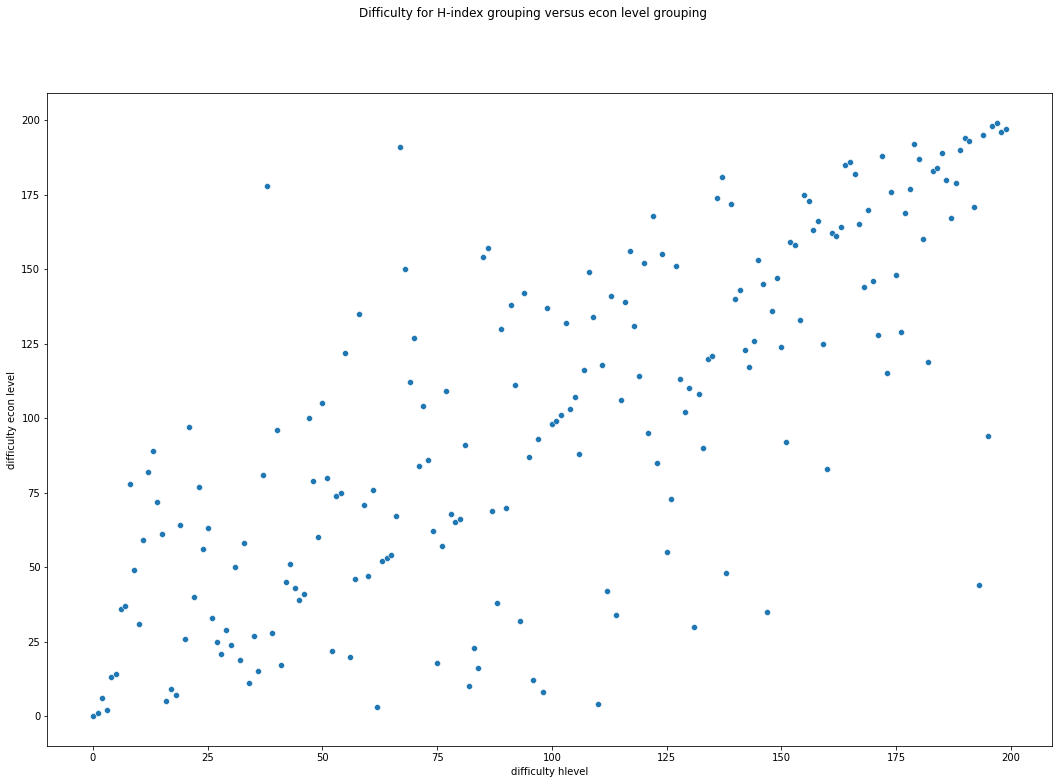

In [24]:
fig, ax = plt.subplots(1,1,figsize=(18,12))

sns.scatterplot(data=edf_m, x='difficulty hlevel', y='difficulty econ level',ax=ax)
fig.suptitle('Difficulty for H-index grouping versus econ level grouping')

We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [25]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137


In [26]:
edf.head(10)

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137
16,54538,0.079392,1.197696,0.965188
5,35778,0.081251,2.346751,2.035454
18,77011,0.085723,1.481183,1.187527
17,27887,0.093059,1.424888,1.064807
6,96265,0.099204,1.580828,1.207824


In [27]:
edf.tail(10)

key,qid,difference,disparity,relevance
189,82759,1.226056,1.560710,0.814788
195,5762,1.294812,1.502517,0.729334
179,24848,1.301109,1.379137,0.843959
191,76875,1.574702,1.746644,0.702895
190,30631,1.629548,1.664027,0.639250
194,11856,1.940051,1.973158,0.430775
198,31412,2.370984,2.037910,0.439675
199,111469,2.474095,2.170630,0.453522
196,47984,2.547254,2.478274,0.368622
197,33337,2.723570,2.321309,0.604961


## Methods

In [ ]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [ ]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

### Methods count per rank

In [27]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [28]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [29]:
def plot_rel_nonrel_per_rank_per_relkind(data,num_rel,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    pi2 = iter(sns.color_palette('dark'))
    f = next(pi)
    f2 = next(pi2)
    s = next(pi)
    s2 = next(pi2)
    next(pi)
    next(pi2)
    t = next(pi)
    t2 = next(pi2)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    colorsf = [f] * num_rel + [f2] * (len(data) - num_rel)
    colorss = [s] * num_rel + [s2] * (len(data) - num_rel)
    
    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],palette=sns.color_palette(colorsf))
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],palette=sns.color_palette(colorss))

    if regline:
        colorst = [t] * num_rel + [t2] * (len(data) - num_rel)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, palette=sns.color_palette(colorst))
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},palette=sns.color_palette(colorst))
    return fig


In [30]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,num_rel_docs,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}, top={num_rel_docs}")
    

### Methods doc occurrence in top positions

In [31]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [32]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [33]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [34]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)

    doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
    rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)

    fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
    fig.suptitle(f"Document counts per rank for {qid}")
    
    

### Methods number of times a doc is in a top position

In [35]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [36]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)
    
    m = pd.merge(unpacked_df,relevance_df[['doc_id','doc_rel']],on='doc_id',how='left')
    return m.drop_duplicates()

In [37]:
def document_pos_count_df_for_qid(qid,ranking,relevance):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)

    
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    return doc_pos_count_df
    

In [180]:
def plot_doc_pos_count(data,numrel,numnrel,sortby=['count'],no_author_ids=None):
    """Plot how many times each document occurred in the top and bottom positions."""
    
    
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by=sortby,ascending=False)
        
     
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [181]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance,sortby=['count'], no_author_ids=None):
    doc_pos_count_df = document_pos_count_df_for_qid(qid,ranking,relevance)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,sortby=sortby,no_author_ids=no_author_ids)

    fig.suptitle(f"Document position counts {qid}")

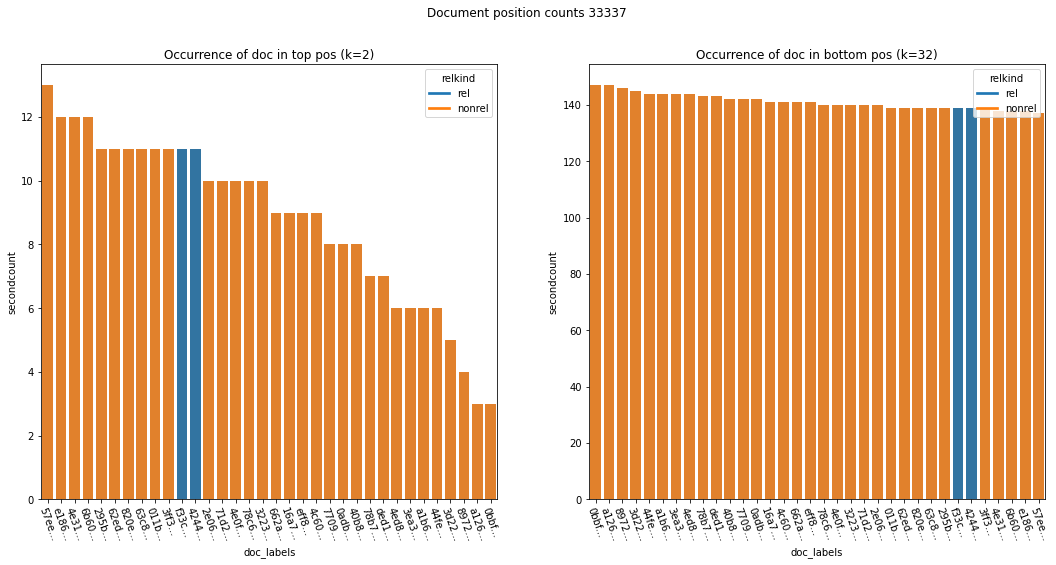

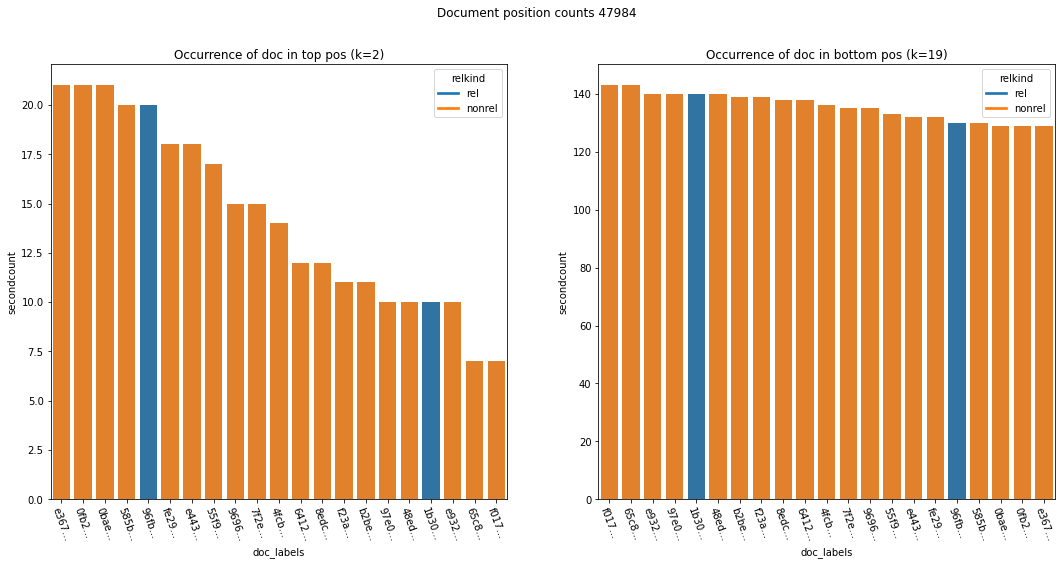

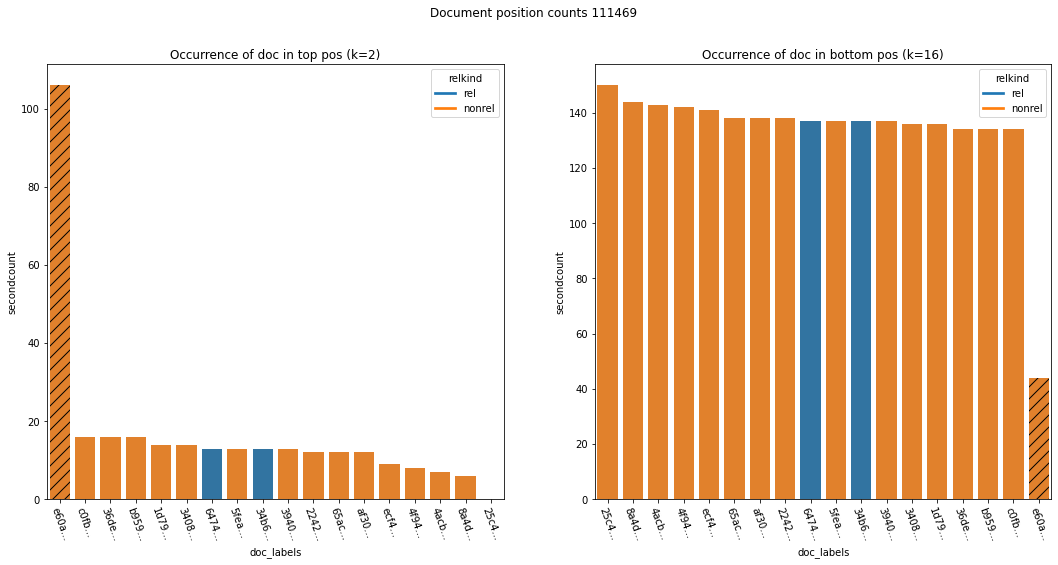

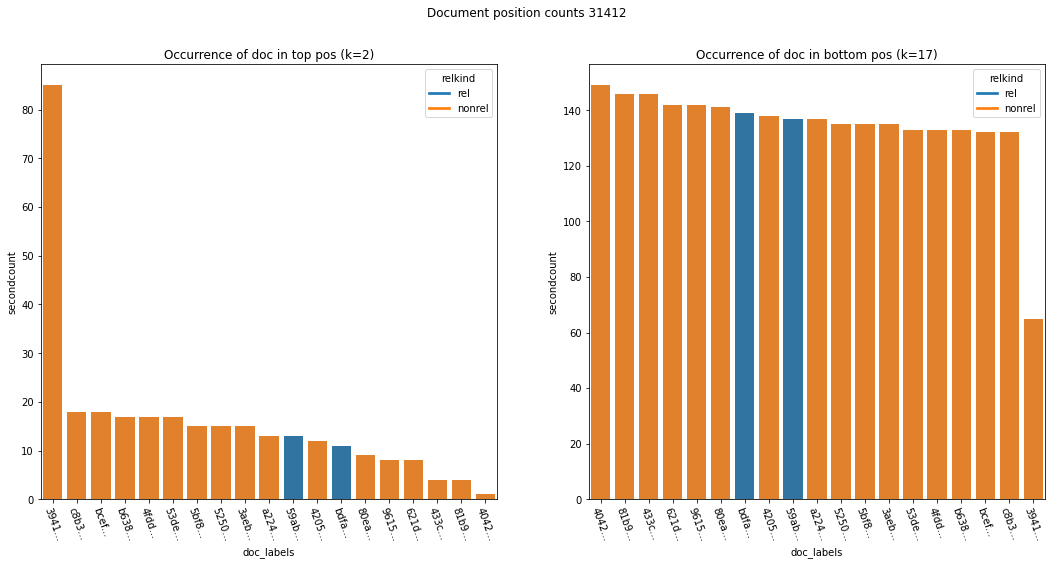

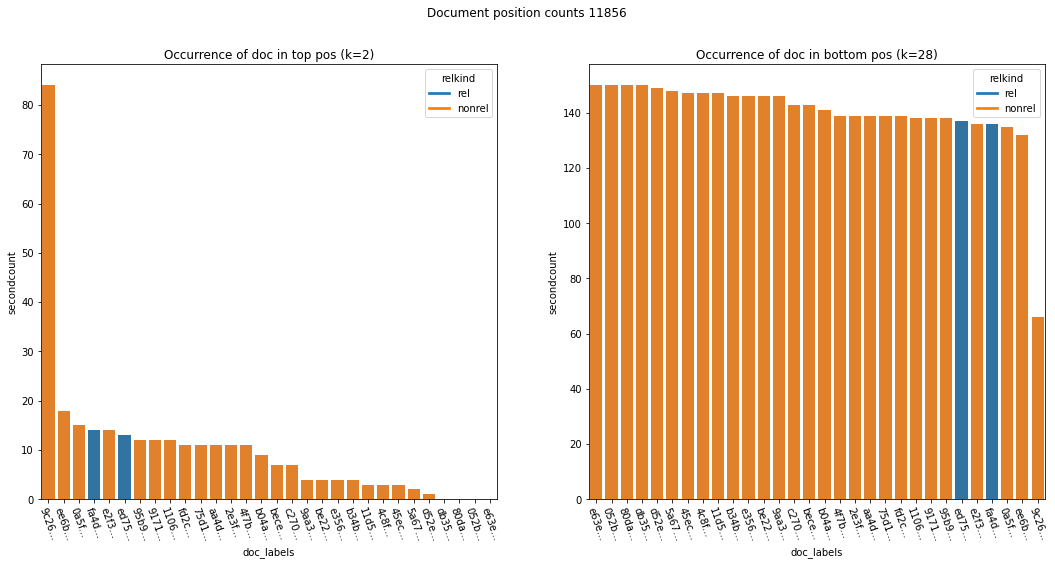

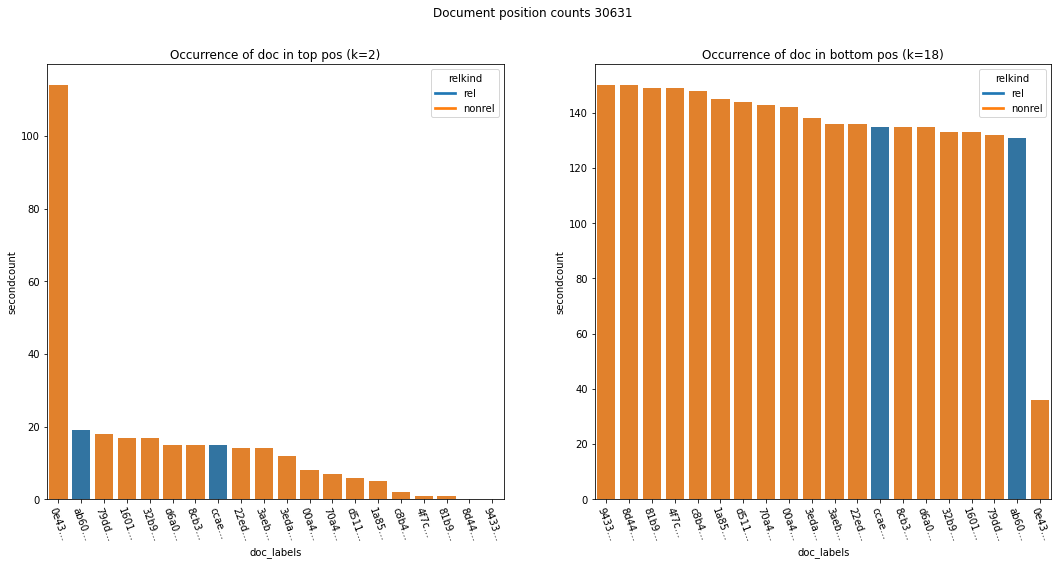

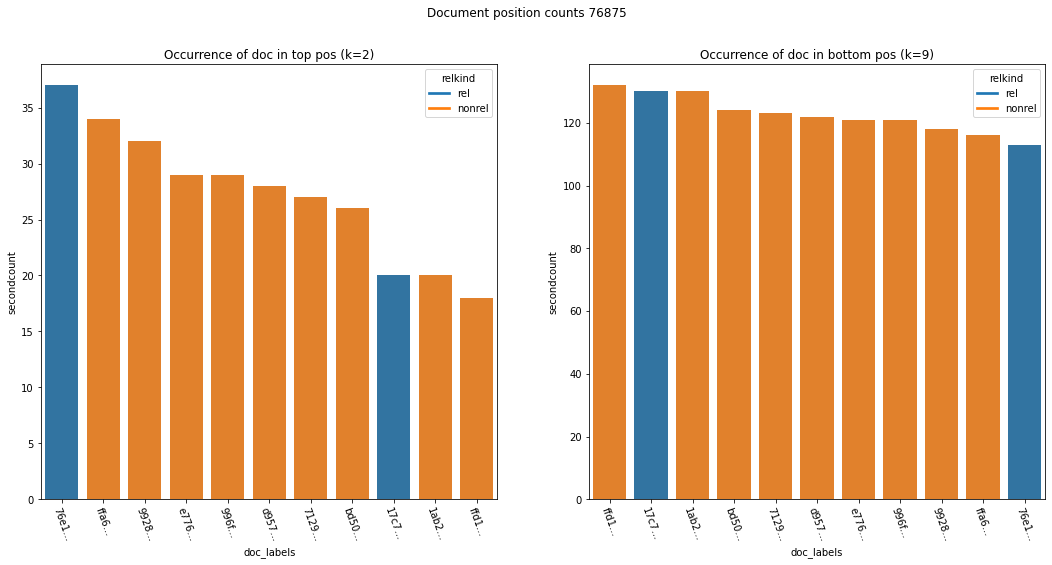

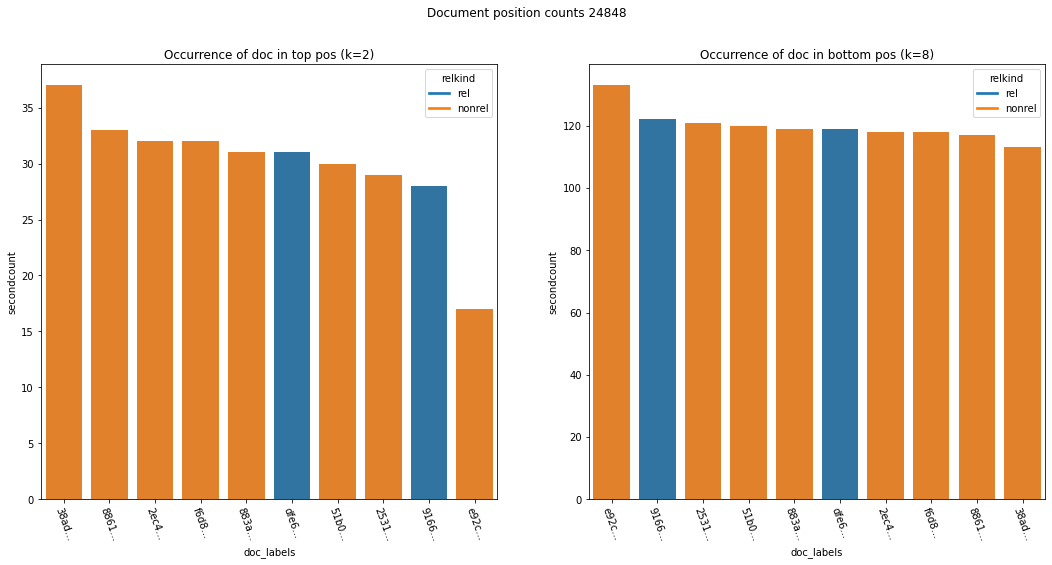

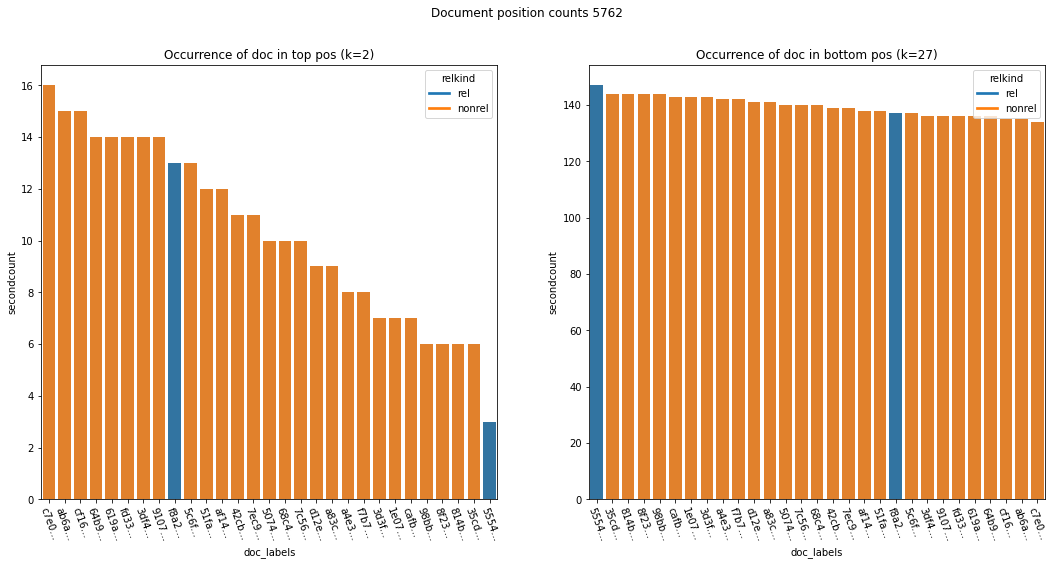

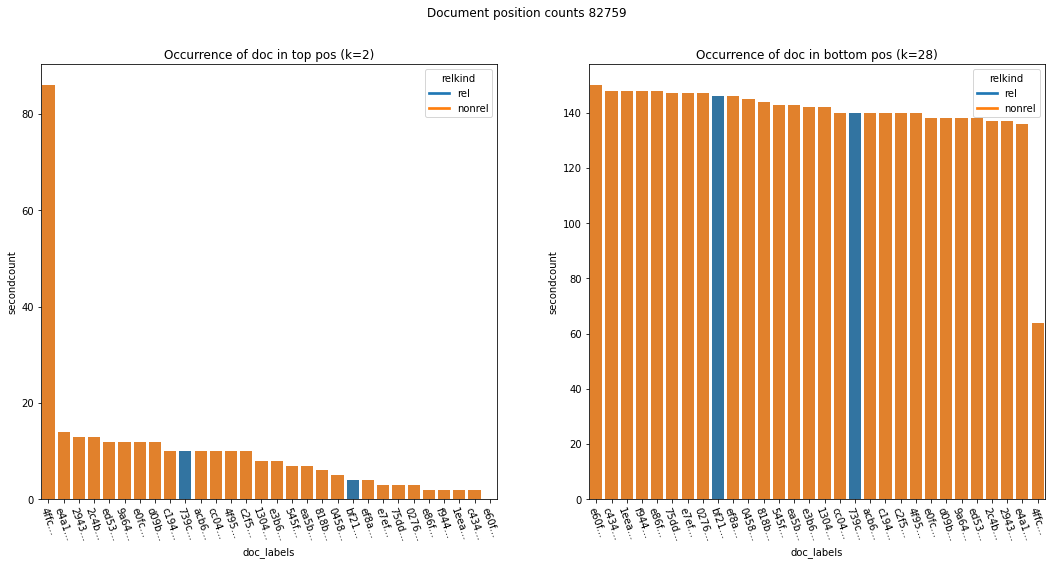

In [182]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,no_author_ids=noauth_ids)

In [186]:
es.search(index='semanticscholar2020og', body={'query':{'ids':{'values':['4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']}}})

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

## Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

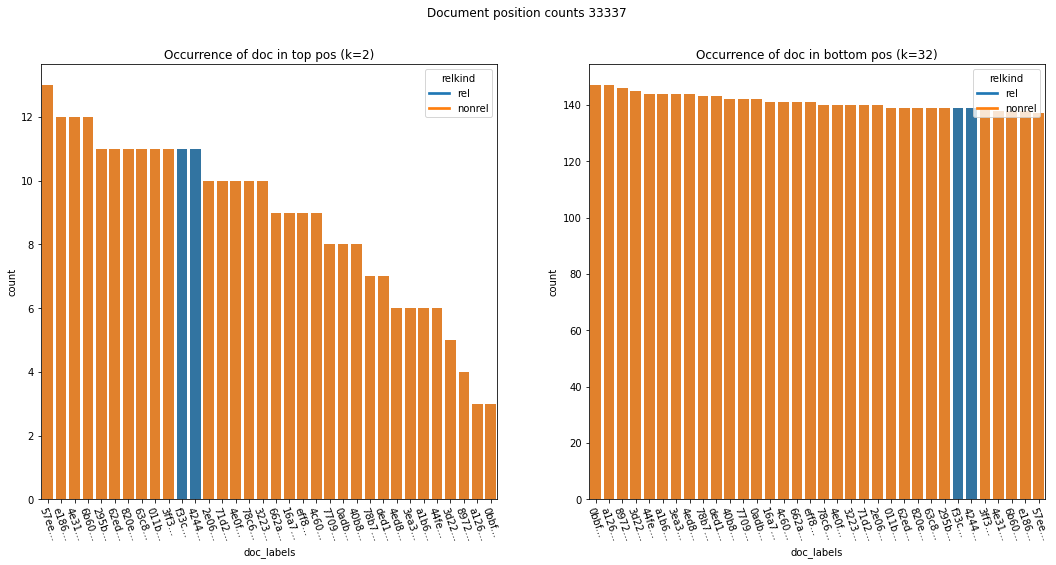

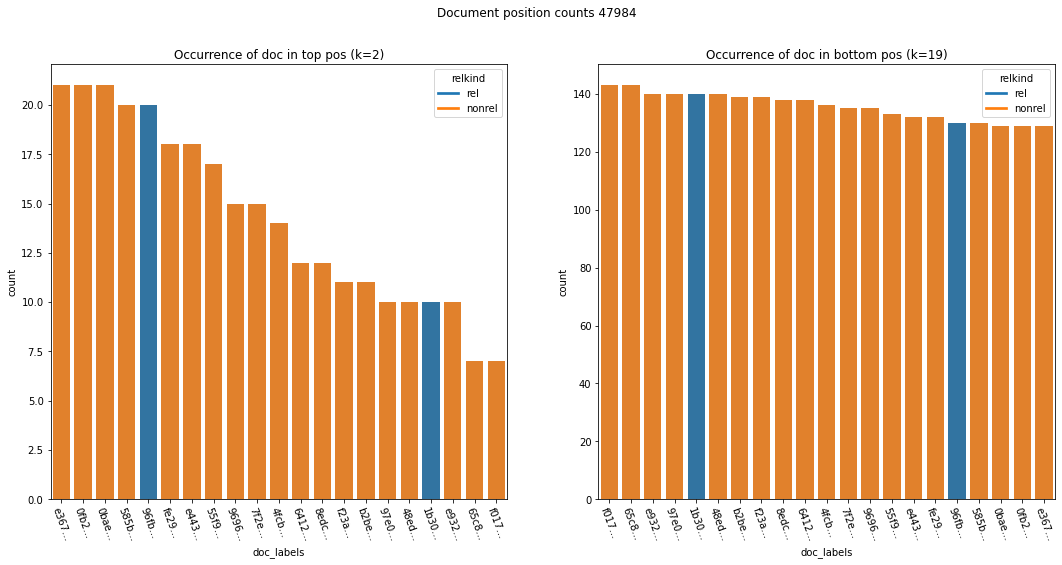

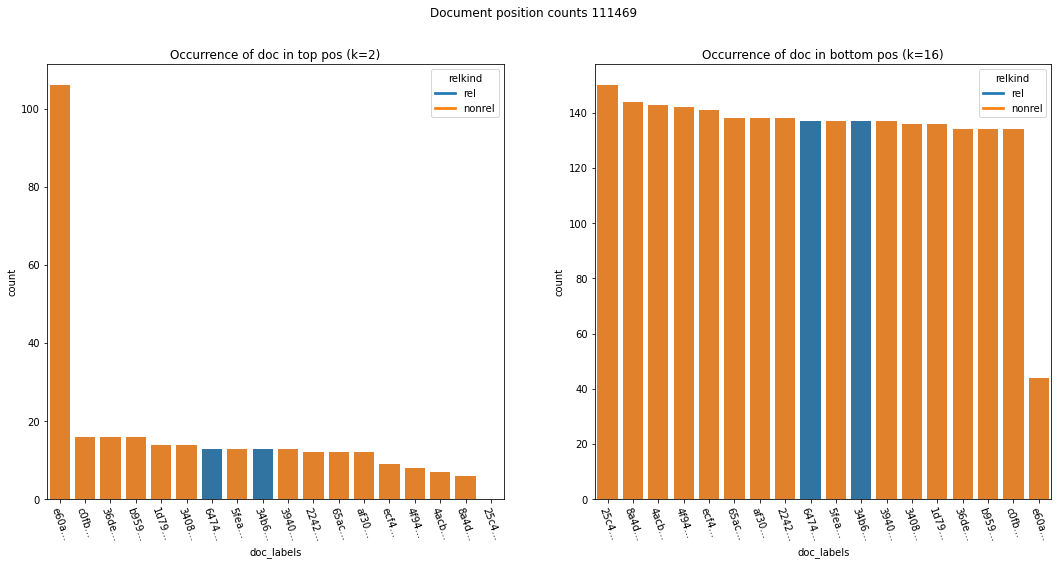

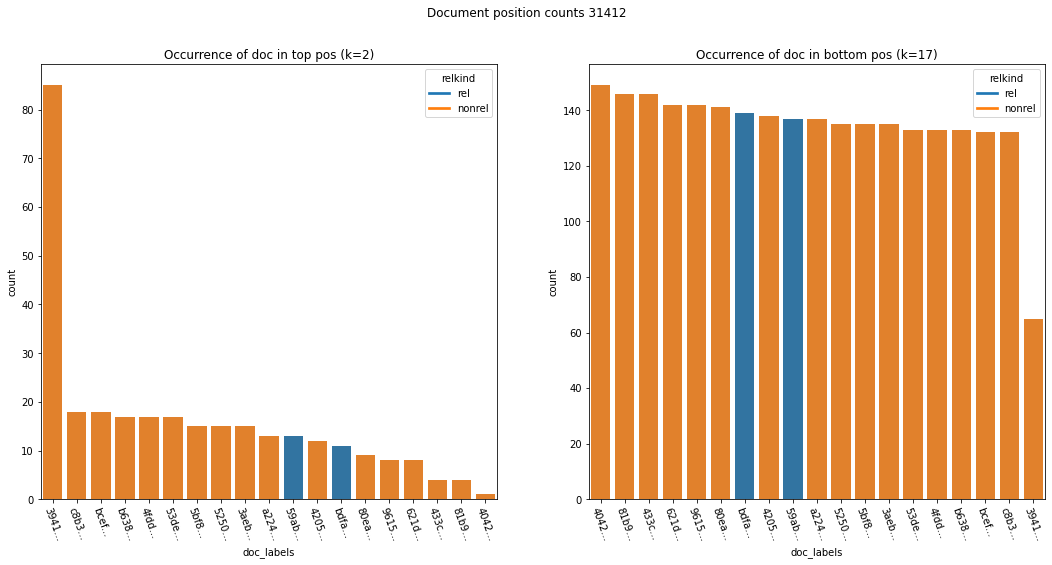

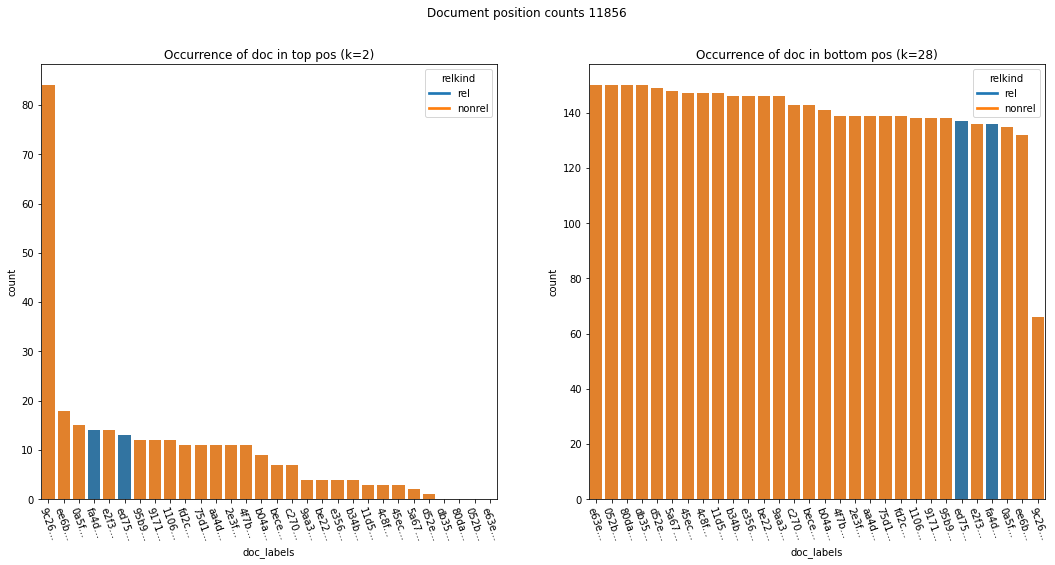

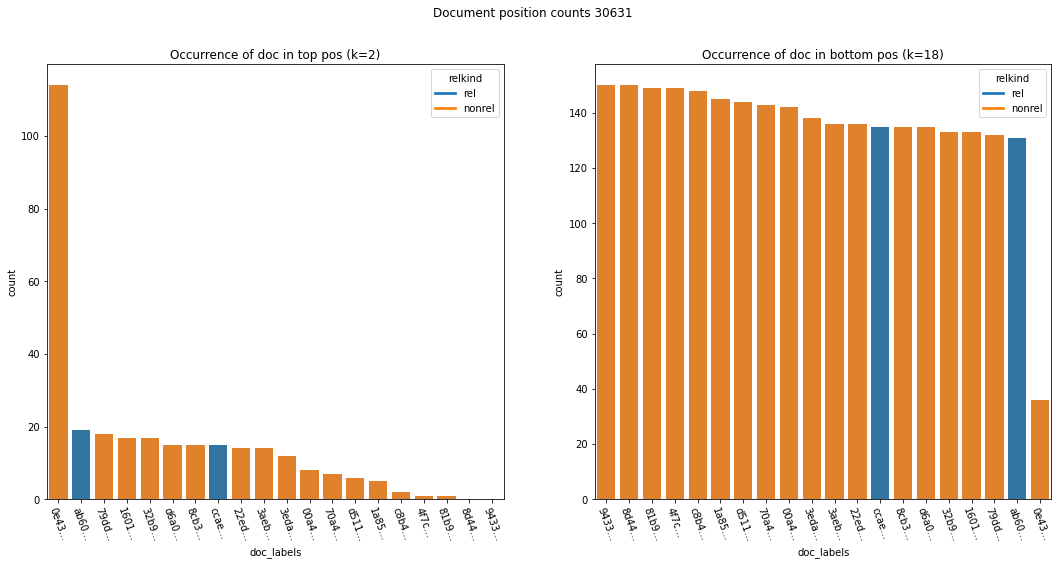

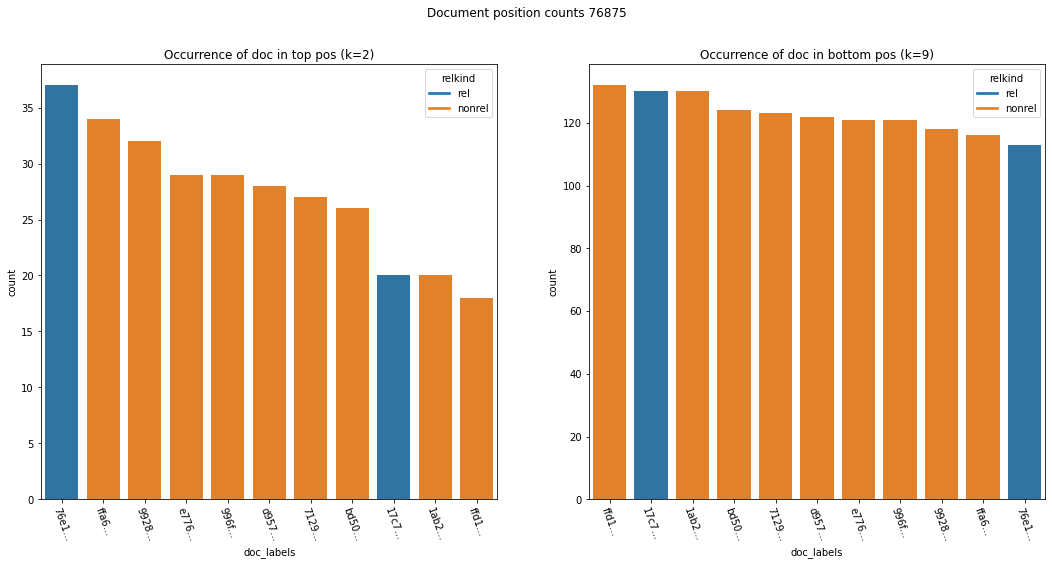

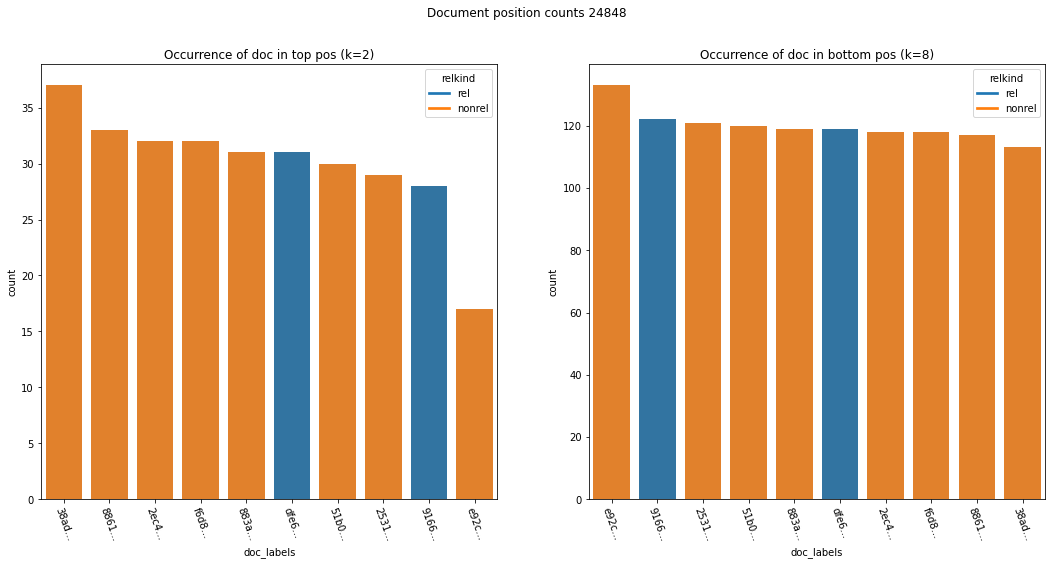

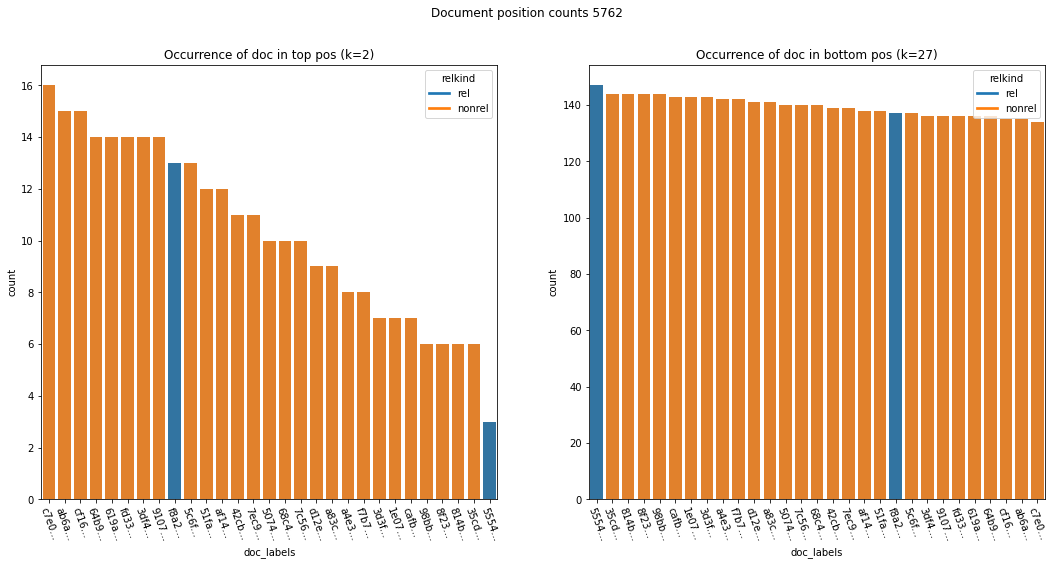

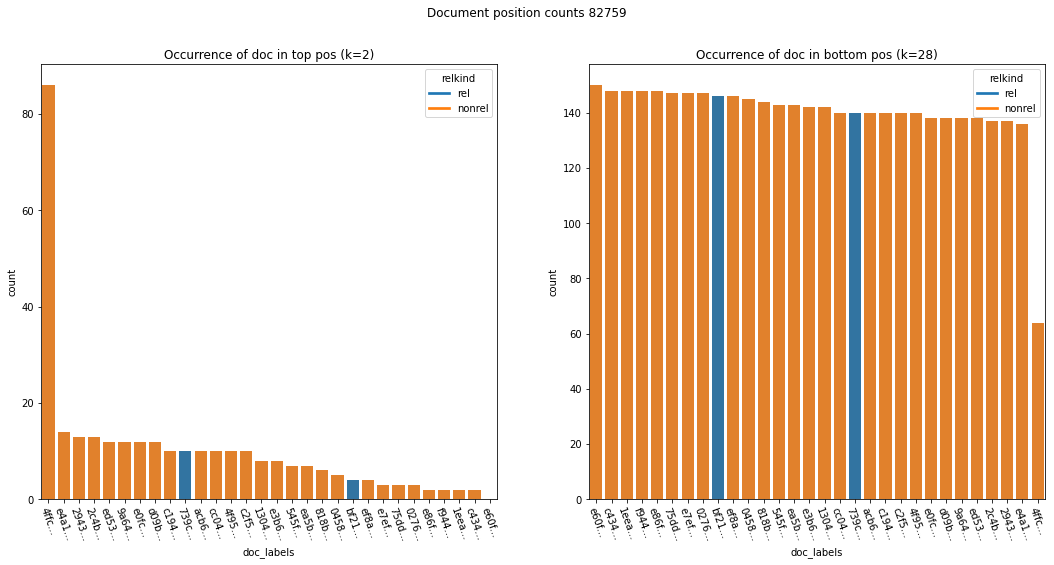

In [40]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

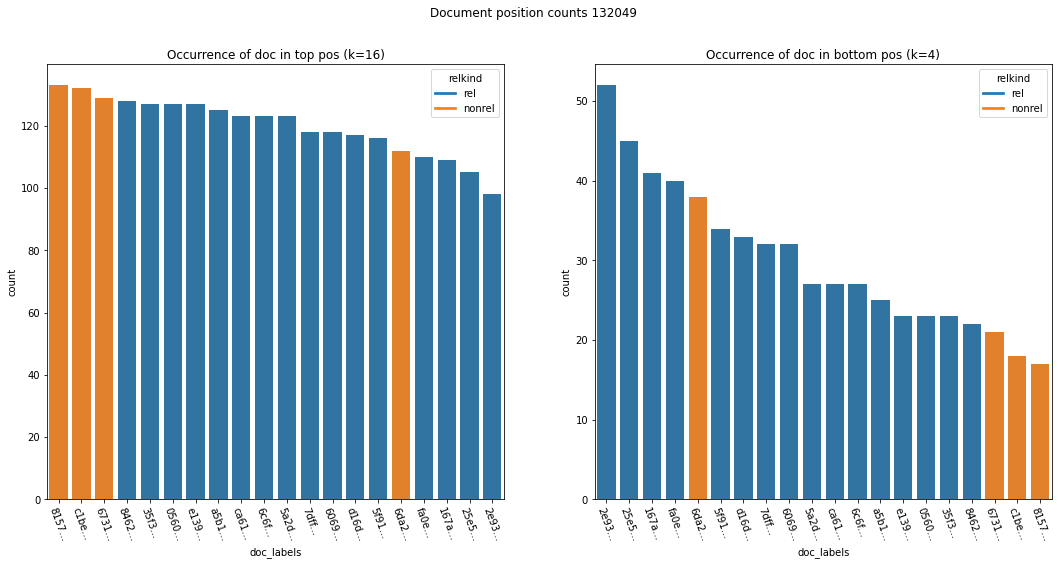

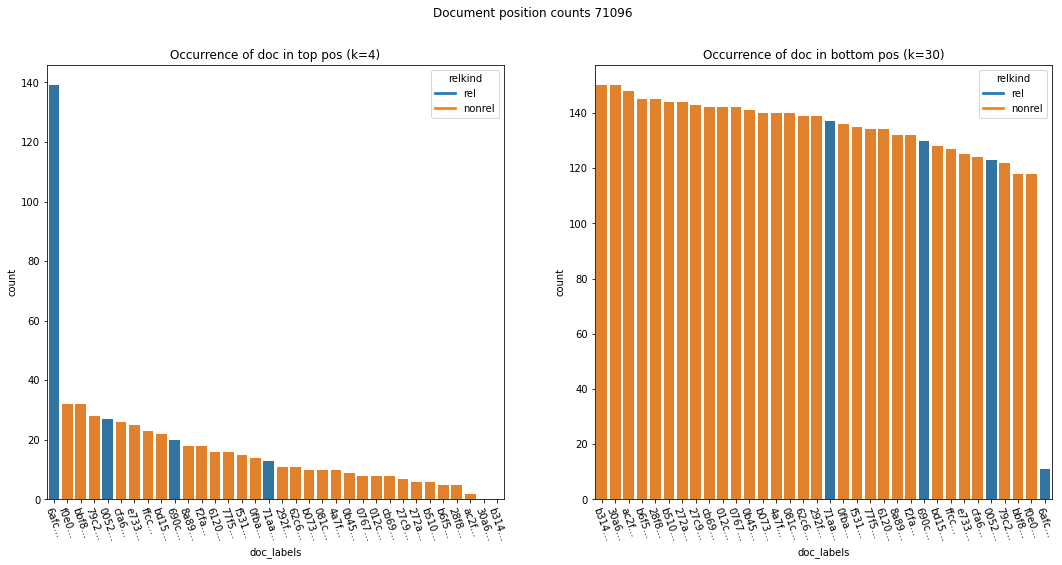

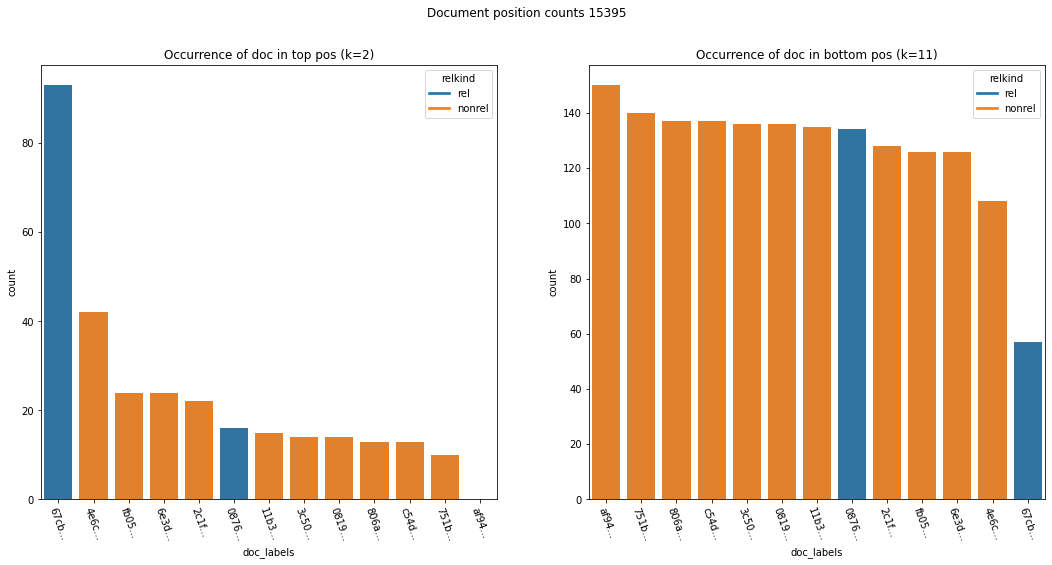

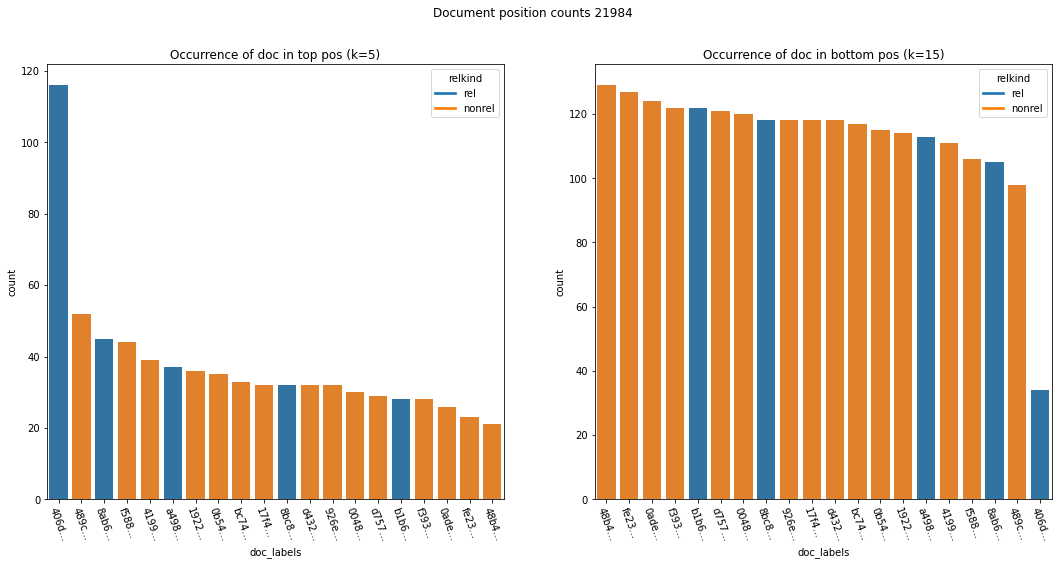

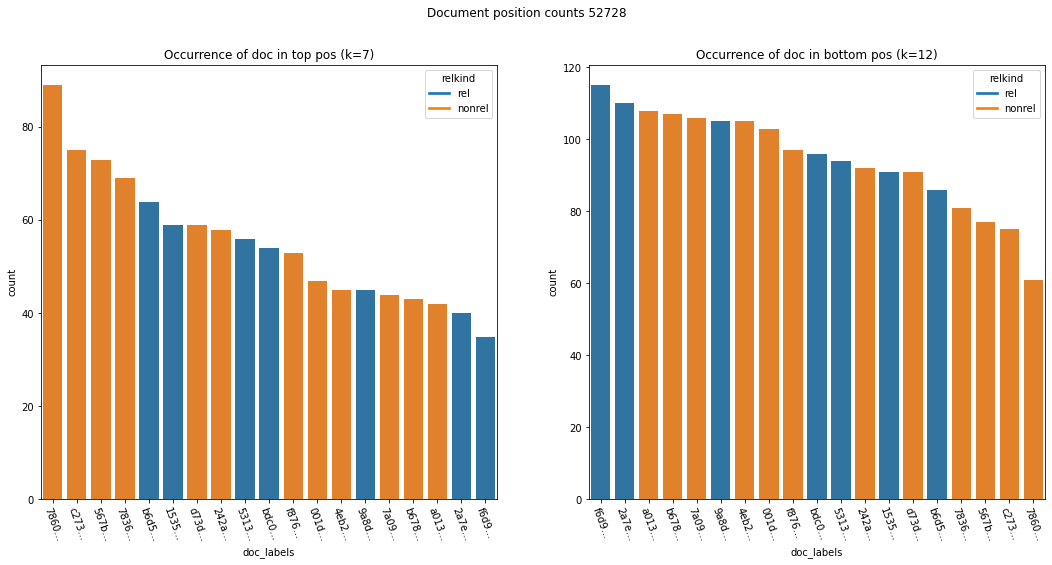

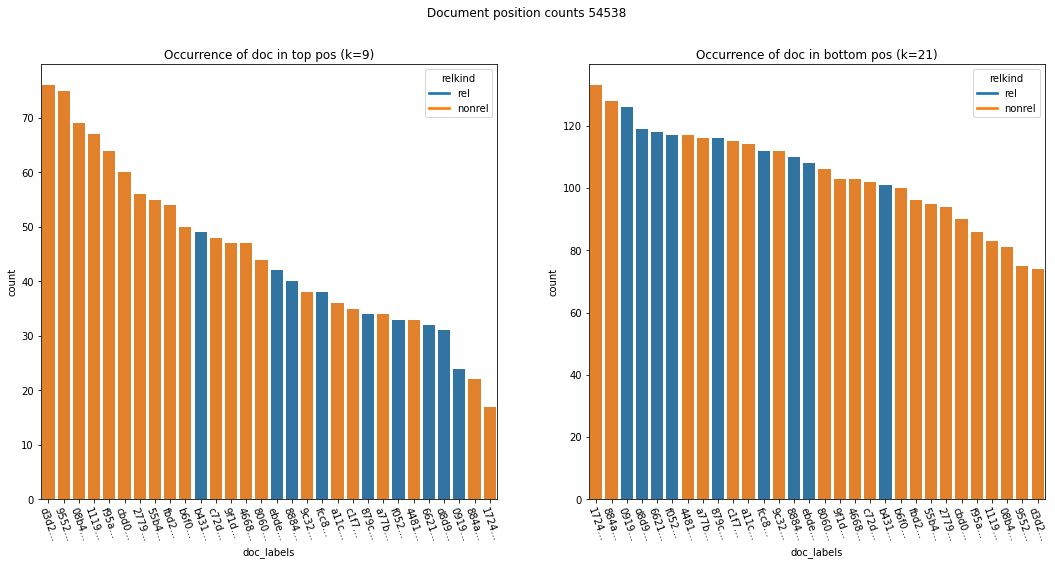

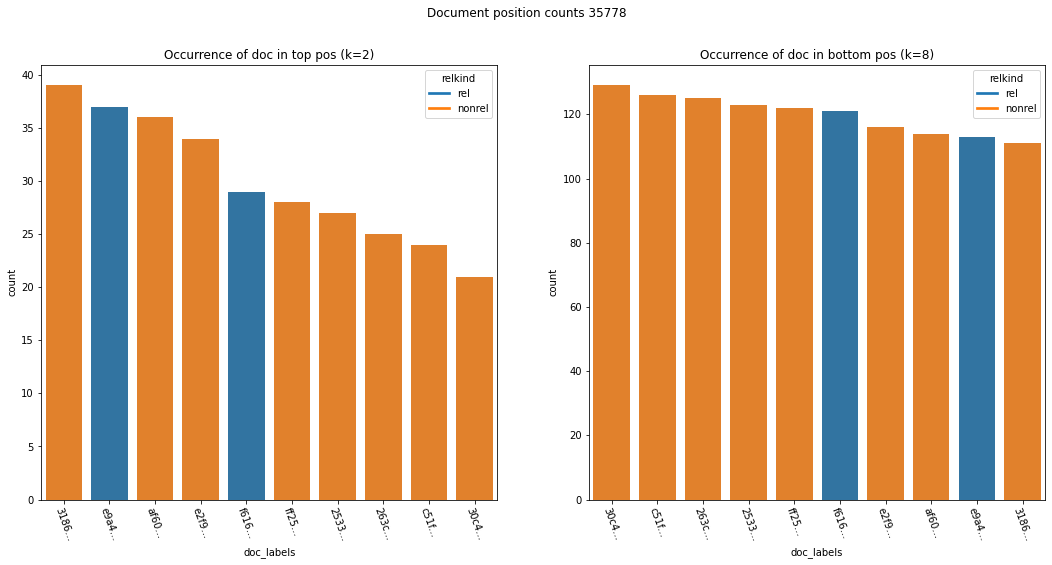

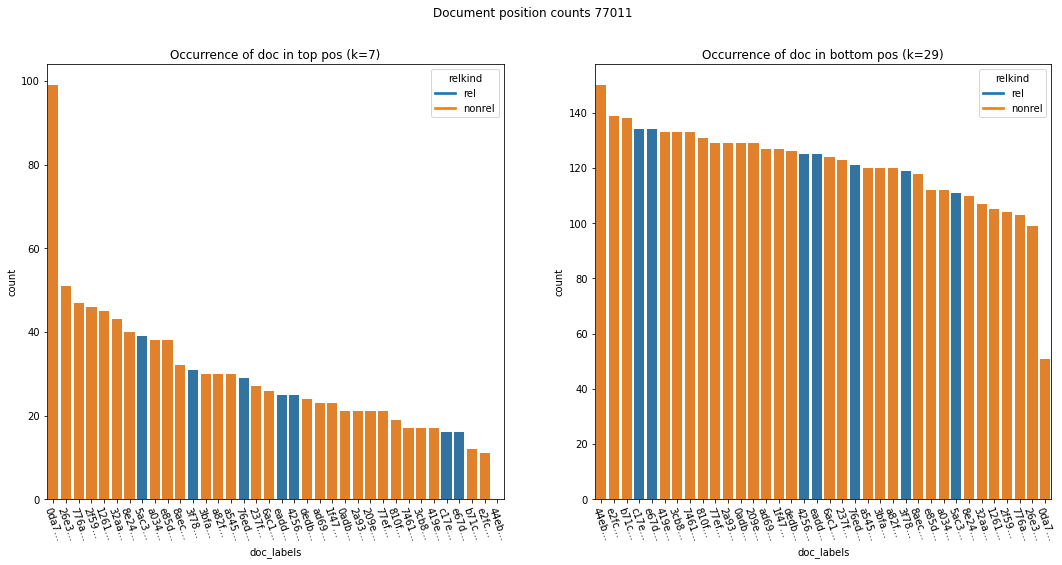

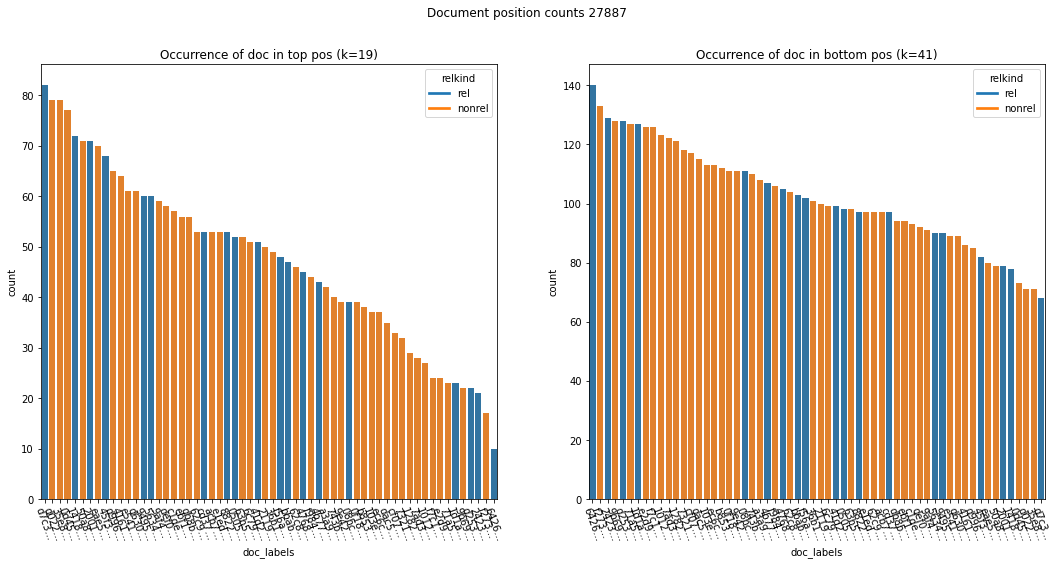

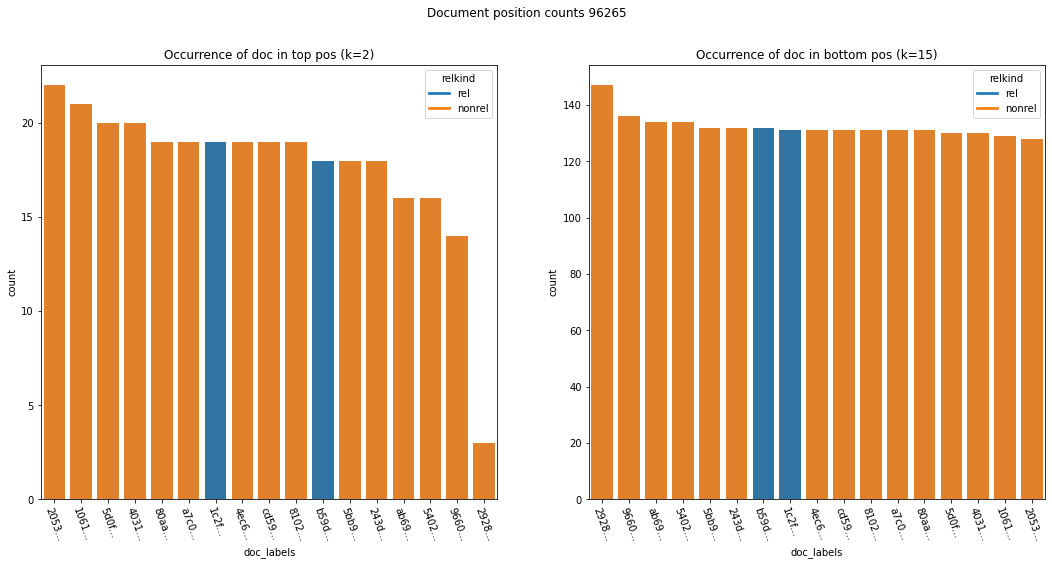

In [41]:
for q in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

## 1. How often were top positions occupied by relevant documents?
Can these documents be categorized and distinguished from others? We want to find out which characteristics of a document help the ranker to place it in the correct location.

#### Percentage of relevant documents

In [42]:
relfrac = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

132049 	 78.92
71096 	 33.17
15395 	 36.33
21984 	 34.4
52728 	 33.62
54538 	 23.93
35778 	 22.0
77011 	 17.24
27887 	 32.28
96265 	 12.33


In [43]:
np.array(relfrac).mean()

32.422

In [44]:
relfrac = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

33337 	 7.33
47984 	 10.0
111469 	 8.67
31412 	 8.0
11856 	 9.0
30631 	 11.33
76875 	 19.0
24848 	 19.67
5762 	 5.33
82759 	 4.67


In [45]:
np.array(relfrac).mean()

10.3

#### Top 25% relevant documents

We find the documents that are in the upper 25 quantile.

In [46]:
inspectlist_top = []
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    if q == 71096:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '6afc97668839a439e6858691ada76c9ddf798c2a']
    if q == 15395:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '67cb7ec0f36f9396b85b18cad90c0d7eec1658ce']
    if q == 21984:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '406d1ef750ba4520b8c57f95596cd42852c0e3fa']
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    # print(doc_pos_count)
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
    inspectlist_top = inspectlist_top + doc_pos_count.doc_id.to_list()
    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    inspectdf = inspectdf.append(doc_pos_count)
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    print()
inspectdf

qid	doc_id	pos	count	doc_rel
 132049  8462f4b6590713db112d6fc665b43cfeb88bab41  top  128  1
 132049  35f38d22d658330d980eb78f4774ad1a68a11e30  top  127  1
 132049  0560a08ef071d54a60f2efac0bf3a6505ae36910  top  127  1
 132049  e13918f61745d29a2e84101ebfc46e9487d38fca  top  127  1

 71096  00525dd393d8a3a72e584eda8328ace8d43f3c0e  top  27  1
 71096  690ca77ec86c43e568e26494d7ddf263d3371ad9  top  20  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

 21984  8ab6f377ac5bc251813b023a47d64bcce5a1cdda  top  45  1
 21984  a4989444cddd8619625492c4ceb037bb496ad253  top  37  1

 52728  b6d58f6d006acfe4df4e4b0e30f5c070738fba5b  top  64  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

 35778  e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc  top  37  1

 77011  5ac38297a3c256c88a67597fa8f5d0c44d5957c8  top  39  1

 27887  d7c3098f185b67cd249b270544058a1b159653f8  top  82  1
 27887  14187497d25732666bd05185037f6048fc5fef8c  top  72  1
 27887  2001acc8ab72f8

,count,doc_id,doc_rel,pos,qid,topbot
24,128,8462f4b6590713db112d6fc665b43cfeb88bab41,1,top,132049,top
22,127,35f38d22d658330d980eb78f4774ad1a68a11e30,1,top,132049,top
26,127,0560a08ef071d54a60f2efac0bf3a6505ae36910,1,top,132049,top
20,127,e13918f61745d29a2e84101ebfc46e9487d38fca,1,top,132049,top
12,27,00525dd393d8a3a72e584eda8328ace8d43f3c0e,1,top,71096,top
24,20,690ca77ec86c43e568e26494d7ddf263d3371ad9,1,top,71096,top
26,45,8ab6f377ac5bc251813b023a47d64bcce5a1cdda,1,top,21984,top
20,37,a4989444cddd8619625492c4ceb037bb496ad253,1,top,21984,top
26,64,b6d58f6d006acfe4df4e4b0e30f5c070738fba5b,1,top,52728,top
4,37,e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc,1,top,35778,top


In [47]:
inspectlist_bottom = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        inspectdf = inspectdf.append(doc_pos_count)
        print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
        print()
inspectlist_bottom
inspectdf

qid	doc_id	pos	count	doc_rel
 33337  f33c709a637322a2eec2ab2d35cb4f17f3da9f71  top  11  1
 33337  4244f5595bc6ddf93eb0e5c568b5967134652f27  top  11  1

 47984  96fb6950aba868ff4a6e8f96bd232cf84e5c6da3  top  20  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

 11856  fa4ddfc3df658ae1451047ed8904a3184154ad2a  top  14  1
 11856  ed754334e13b44d53523b65a807ebc23497623e7  top  13  1

 30631  ab609df01b35223d4c1ec4d6fe84cfe349ad608b  top  19  1

 76875  76e199fcf5537c4e8ef774d792afd2978aa11ebb  top  37  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []



,count,doc_id,doc_rel,pos,qid,topbot
24,128,8462f4b6590713db112d6fc665b43cfeb88bab41,1,top,132049,top
22,127,35f38d22d658330d980eb78f4774ad1a68a11e30,1,top,132049,top
26,127,0560a08ef071d54a60f2efac0bf3a6505ae36910,1,top,132049,top
20,127,e13918f61745d29a2e84101ebfc46e9487d38fca,1,top,132049,top
12,27,00525dd393d8a3a72e584eda8328ace8d43f3c0e,1,top,71096,top
24,20,690ca77ec86c43e568e26494d7ddf263d3371ad9,1,top,71096,top
26,45,8ab6f377ac5bc251813b023a47d64bcce5a1cdda,1,top,21984,top
20,37,a4989444cddd8619625492c4ceb037bb496ad253,1,top,21984,top
26,64,b6d58f6d006acfe4df4e4b0e30f5c070738fba5b,1,top,52728,top
4,37,e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc,1,top,35778,top


In [48]:
inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
24,128,8462f4b6590713db112d6fc665b43cfeb88bab41,1,top,132049,top
22,127,35f38d22d658330d980eb78f4774ad1a68a11e30,1,top,132049,top
26,127,0560a08ef071d54a60f2efac0bf3a6505ae36910,1,top,132049,top
20,127,e13918f61745d29a2e84101ebfc46e9487d38fca,1,top,132049,top
12,27,00525dd393d8a3a72e584eda8328ace8d43f3c0e,1,top,71096,top
24,20,690ca77ec86c43e568e26494d7ddf263d3371ad9,1,top,71096,top
26,45,8ab6f377ac5bc251813b023a47d64bcce5a1cdda,1,top,21984,top
20,37,a4989444cddd8619625492c4ceb037bb496ad253,1,top,21984,top
26,64,b6d58f6d006acfe4df4e4b0e30f5c070738fba5b,1,top,52728,top
4,37,e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc,1,top,35778,top


### Spikes

#### Estimated relevances

In [49]:
est_rel_meta.est_relevance.max()

0.262876905714192

In [50]:
est_rel_meta.est_relevance.min()

4.12674355270539e-09

##### 71096

In [51]:
est_rel_meta[(est_rel_meta.qid == 71096) & (est_rel_meta.doc_id == '6afc97668839a439e6858691ada76c9ddf798c2a')]

,qid,doc_id,relevance,est_relevance
432,71096,6afc97668839a439e6858691ada76c9ddf798c2a,1,0.218468


In [52]:
est_rel_meta[(est_rel_meta.qid == 71096)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
441,71096,b3146d2601f32d068162d2eb954ed864859bb1cd,0,0.029874
448,71096,30a698ba5648295c91f00545326931eaf07b00be,0,0.069391
455,71096,ac2f1bf955e79c2522573fb8f508637a9cb272bf,0,0.095152
439,71096,cb6940faebc08e4e03c4cfd3adffa567c0946fb2,0,0.095528
452,71096,292f1c65fb0a3995411f516e3dc501e44a3fed07,0,0.098981
436,71096,012c336ff0a7229cd2c4809f26d9a85e15882bbc,0,0.100853
447,71096,b51099d190c827fdfed93b7a459d0808d38ccddb,0,0.105284
458,71096,8a892b91e318de54b25809000e818a5efc23d696,0,0.116082
428,71096,0767627edb30ac03c910afea561ecc226d4de87a,0,0.120897
440,71096,27c92ca493b24d253ef0ad1a3f8c72452f30b3ee,0,0.128345


Est rel one of the highest.

##### 15395

In [53]:
est_rel_meta[(est_rel_meta.qid == 15395) & (est_rel_meta.doc_id == '67cb7ec0f36f9396b85b18cad90c0d7eec1658ce')]

,qid,doc_id,relevance,est_relevance
1101,15395,67cb7ec0f36f9396b85b18cad90c0d7eec1658ce,1,0.070658


In [54]:
est_rel_meta[(est_rel_meta.qid == 15395)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
1101,15395,67cb7ec0f36f9396b85b18cad90c0d7eec1658ce,1,0.070658
1105,15395,751b1a631daaabbd0e9376b40005c07ca07a5b29,0,0.086387
1106,15395,c54d65d53d7ada275d34e1a7c53643ff0c82eb93,0,0.124888
1112,15395,08196a4be3e863dd152b3f71aa25e7aeabb6faec,0,0.127366
1100,15395,806a330219f49b6e7952e79444477ef512501650,0,0.131350
1102,15395,3c50b229b9a59de264df893f6444d515f2546ca1,0,0.136192
1104,15395,11b35902e5de5d96046b2db4670e756f1e3a1a3e,0,0.139865
1110,15395,08761cfc723bc5dafd6e18203aff6392ae46bd2b,1,0.165807
1108,15395,af94eb52e8f7a52b1800414646ab729f34da9191,0,0.177854
1109,15395,6e3d8390a0129602e4680baeb9a87ff2b89b7db4,0,0.180306


Est rel the lowest.

##### 21984 

In [55]:
est_rel_meta[(est_rel_meta.qid == 21984) & (est_rel_meta.doc_id == '406d1ef750ba4520b8c57f95596cd42852c0e3fa')]

,qid,doc_id,relevance,est_relevance
828,21984,406d1ef750ba4520b8c57f95596cd42852c0e3fa,1,0.079451


In [56]:
est_rel_meta[(est_rel_meta.qid == 21984)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
836,21984,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,0.067000
831,21984,d432fd031c1e03c32c1c1a8e39e9c4e7d54dd866,0,0.070256
843,21984,1922e7cc2d1631f46d20ac440940ec6c094c4863,0,0.074406
828,21984,406d1ef750ba4520b8c57f95596cd42852c0e3fa,1,0.079451
835,21984,489c6481f150c07ceb26752a86b5ba1cd863c8de,0,0.107980
844,21984,fe23129607e4a56b1575f0a248ade43363b528d2,0,0.147048
838,21984,8ab6f377ac5bc251813b023a47d64bcce5a1cdda,1,0.152157
839,21984,4199fbc0a70120d237e97973ce2e258e285134ac,0,0.155797
847,21984,f588374552ec0ba6e846ebdaa4fe4b37d1ea8042,0,0.171516
834,21984,a4989444cddd8619625492c4ceb037bb496ad253,1,0.179247


Est rel one of the lowest.

#### Authors

The other factor influencing the h-scores is the author advantage. We know that some documents do not have authors. In our implementation of the algorithm, the advantage of documents without author is (re)set to zero at each iteration. Additionally, some documents are not in the index at all, and as such also do not have authors.


In [57]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = ["6afc97668839a439e6858691ada76c9ddf798c2a", "67cb7ec0f36f9396b85b18cad90c0d7eec1658ce", "406d1ef750ba4520b8c57f95596cd42852c0e3fa"]
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})    

In [58]:
res

{'took': 1854,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '6afc97668839a439e6858691ada76c9ddf798c2a',
    '_score': 1.0,
    '_source': {'title': 'Motivational Interviewing and Transtheoretical Model',
     'paperAbstract': '',
     'entities': [],
     'author_names': [],
     'author_ids': [],
     'inCitations': 1,
     'outCitations': 0,
     'year': None,
     'venue': '',
     'journalName': '',
     'journalVolume': '',
     'sources': [],
     'doi': '',
     'fields_of_study': []}}]}}

### Upper quantile docs

#### Estimated relevances

In [59]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels.head()

,count,doc_id,relevance,pos,qid,topbot,est_relevance
0,128,8462f4b6590713db112d6fc665b43cfeb88bab41,1,top,132049,top,0.179613
1,127,35f38d22d658330d980eb78f4774ad1a68a11e30,1,top,132049,top,0.179613
2,127,0560a08ef071d54a60f2efac0bf3a6505ae36910,1,top,132049,top,0.179613
3,127,e13918f61745d29a2e84101ebfc46e9487d38fca,1,top,132049,top,0.179613
4,27,00525dd393d8a3a72e584eda8328ace8d43f3c0e,1,top,71096,top,0.209185


In [60]:
inspectrels.est_relevance.mean()

0.1704542934585243

In [61]:
inspectrels.est_relevance.min()

0.0753431544305341

In [62]:
inspectrels.est_relevance.max()

0.25201447313180203

In [63]:
inspectrels[inspectrels.topbot == 'top'].est_relevance.mean()

0.1540583339522966

In [64]:
inspectrels[inspectrels.topbot == 'top'].est_relevance.min()

0.0753431544305341

In [65]:
inspectrels[inspectrels.topbot == 'top'].est_relevance.max()

0.20918468598138198

In [66]:
inspectrels[inspectrels.topbot == 'bot'].est_relevance.mean()

0.21261533218882414

In [67]:
inspectrels[inspectrels.topbot == 'bot'].est_relevance.min()

0.191062482088213

In [68]:
inspectrels[inspectrels.topbot == 'bot'].est_relevance.max()

0.25201447313180203

In [69]:
inspectrankings = pd.merge(est_rel_meta,inspectdf,on=['qid','doc_id'],how='outer').sort_values(by=['qid','est_relevance'],ascending=False)

In [70]:
inspectrankings = inspectrankings[inspectrankings.qid.isin(inspectdf.qid.tolist())]

In [71]:
for qid in inspectrankings.qid.drop_duplicates().to_list():
    inspectrankings[inspectrankings.qid == qid][['qid','doc_id','est_relevance','topbot']]
    

In [72]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    # print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

#### Authors

##### Do top docs all have an author?

In [73]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [74]:
from collections import Counter

In [75]:
Counter(inspect_ids)

Counter({'8462f4b6590713db112d6fc665b43cfeb88bab41': 1,
         '35f38d22d658330d980eb78f4774ad1a68a11e30': 1,
         '0560a08ef071d54a60f2efac0bf3a6505ae36910': 1,
         'e13918f61745d29a2e84101ebfc46e9487d38fca': 1,
         '00525dd393d8a3a72e584eda8328ace8d43f3c0e': 1,
         '690ca77ec86c43e568e26494d7ddf263d3371ad9': 1,
         '8ab6f377ac5bc251813b023a47d64bcce5a1cdda': 1,
         'a4989444cddd8619625492c4ceb037bb496ad253': 1,
         'b6d58f6d006acfe4df4e4b0e30f5c070738fba5b': 1,
         'e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc': 1,
         '5ac38297a3c256c88a67597fa8f5d0c44d5957c8': 1,
         'd7c3098f185b67cd249b270544058a1b159653f8': 1,
         '14187497d25732666bd05185037f6048fc5fef8c': 1,
         '2001acc8ab72f8f40dab07e5a76d414fe748a90b': 1,
         '45f34e166883427eab85964fb3ef74277109bd18': 1,
         '9495c1fac28d48e2b56c74624aab3af1ebf677f4': 1,
         '56349aed8de5de494ca19ee6963bbb25c1a11cfb': 1,
         '1c2fc3db949b0ec866ba6a636182860754def1

##### Do top rel docs have few or many authors? Do those authors have few or many docs?

In [76]:
list(set(inspectdf.qid.to_list()))

[21984,
 35778,
 30631,
 52728,
 96265,
 76875,
 27887,
 47984,
 132049,
 11856,
 77011,
 71096,
 33337]

In [77]:

for qid in list(set(inspectdf.qid.to_list())):
    authors = []
    for did in inspectdf[inspectdf.qid == qid].doc_id.to_list():
        print(qid, "\t, ",did,", ", doc_to_author[did])
        for au in doc_to_author[did]:
             print(au, '\t,', author_to_doc[au])
        print()
       
    print()

21984 	,  8ab6f377ac5bc251813b023a47d64bcce5a1cdda ,  ['39640677', '3899779', '4382086']
39640677 	, ['8ab6f377ac5bc251813b023a47d64bcce5a1cdda']
3899779 	, ['8ab6f377ac5bc251813b023a47d64bcce5a1cdda']
4382086 	, ['8ab6f377ac5bc251813b023a47d64bcce5a1cdda']

21984 	,  a4989444cddd8619625492c4ceb037bb496ad253 ,  ['36882735', '2736307', '5243739', '39030889', '35277226', '6257279', '3294707', '1843726', '3215557', '2710870']
36882735 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
2736307 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
5243739 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
39030889 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
35277226 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
6257279 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
3294707 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
1843726 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
3215557 	, ['a4989444cddd8619625492c4ceb037bb496ad253']
2710870 	, ['a4989444cddd8619625492c4ceb037bb496ad253']


35778 	,

Most of these top relevant documents have an author that only wrote that specific document.

Exceptions are:
- 54538,  091904c2b9d8ef6fe127b97d461c8e51d20237be, '5809541'
- 54538 	,  d8d969c4c74f2759e0eccd9fd5b6b775036650f1 ,  ['6370151']
- 76875 	,  17c780c1aca508a3172fa0d5dd1bf10168a10f54 ,  ['1685825']
- 27887 	,  6426c1444b4b397982ae1b8782dba53ad662fbeb ,  ['40961249']
- 132049 	,  2e93445410af33f0c377ed65bcc4ac74a8826ae2 ,  ['3127756']
- 132049 	,  2e93445410af33f0c377ed65bcc4ac74a8826ae2 ,  ['2300588']
...


#### Difference predicted relevance score and actual relevance score

In [78]:
inspectrels['reldiff'] = inspectrels.apply(lambda row: row.relevance - row.est_relevance, axis = 1)
print(inspectrels[inspectrels.topbot == 'top'].reldiff.mean())
print(inspectrels[inspectrels.topbot == 'bot'].reldiff.mean())

0.8459416660477035
0.7873846678111758


## 2. How often were top positions occupied by non-relevant documents? 
Can these documents be categorized and distinguished from other documents?

### Computation
1. What percentage of the top positions was occupied by relevant documents?  
    a. Which relevant documents were most often in a top position? 
        - More specifically: which relevant documents were more often in a top position than any other document for the ranking?    
            - Which relevant documents were among the top 75% of the documents in the top positions, frequency-wise.
2. What was their predicted relevance score?  
3. What was their author?  
    - Did their author write more of the documents in the ranking?

#### Percentage of non-relevant documents

In [79]:
fraclist = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

132049 	 21.08
71096 	 66.83
15395 	 63.67
21984 	 65.6
52728 	 66.38
54538 	 76.07
35778 	 78.0
77011 	 82.76
27887 	 67.72
96265 	 87.67


In [80]:
np.array(fraclist).mean()

67.578

In [81]:
fraclist = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

33337 	 92.67
47984 	 90.0
111469 	 91.33
31412 	 92.0
11856 	 91.0
30631 	 88.67
76875 	 81.0
24848 	 80.33
5762 	 94.67
82759 	 95.33


In [82]:
np.array(fraclist).mean()

89.7

#### Most frequent non-relevant documents

In [83]:
toptoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')  & (doc_pos_count.doc_rel == 0)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    toptoplist = toptoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
toptoplist

qid	doc_id	pos	count	doc_rel
 132049  8157ceeb5c2cb3abdcd4347a7fae3377d25959d9  top  133  0

 71096  f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a  top  32  0
 71096  bbf84c2e04321f3f5813cdc91978a186727bbe05  top  32  0

 15395  4e6c4288338eba5644ead3847e11cd50bdee973d  top  42  0

 21984  489c6481f150c07ceb26752a86b5ba1cd863c8de  top  52  0

 52728  78600073012747814a2293cceb58658df5ca3899  top  89  0

 54538  d3d2047b64752b0f7faffaf51084fb5c0212d54f  top  76  0

 35778  318686213deb625007388f23154c9670b886789c  top  39  0

 77011  0da7a3f0c7d130412c61687521f60f3d06d41bcd  top  99  0

 27887  35e87d3aa8eabaa910a0c1d172600823b15b691d  top  79  0
 27887  d02256277cd349c75ba40ba5bd370ec43099c7b0  top  79  0

 96265  2053d9e5eed846080dbd531b94daf0628b2125d3  top  22  0



['8157ceeb5c2cb3abdcd4347a7fae3377d25959d9',
 'f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a',
 'bbf84c2e04321f3f5813cdc91978a186727bbe05',
 '4e6c4288338eba5644ead3847e11cd50bdee973d',
 '489c6481f150c07ceb26752a86b5ba1cd863c8de',
 '78600073012747814a2293cceb58658df5ca3899',
 'd3d2047b64752b0f7faffaf51084fb5c0212d54f',
 '318686213deb625007388f23154c9670b886789c',
 '0da7a3f0c7d130412c61687521f60f3d06d41bcd',
 '35e87d3aa8eabaa910a0c1d172600823b15b691d',
 'd02256277cd349c75ba40ba5bd370ec43099c7b0',
 '2053d9e5eed846080dbd531b94daf0628b2125d3']

In [84]:
tailtoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.tail(10).iloc[::-1].qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top') & (doc_pos_count.doc_rel == 0)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    tailtoplist = tailtoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
tailtoplist

qid	doc_id	pos	count	doc_rel
 33337  57ee023985eaea6055b84bef61d8de9da5f6ca9a  top  13  0

 47984  0baed861c47a5954128212057b0f3f2cc1898b9d  top  21  0
 47984  e3670b0984e4690226c5dbc5ae55f9ce7d3782ed  top  21  0
 47984  0fb2374bf367ce7a243d9db00a57574ef2cc6a3e  top  21  0

 111469  e60af557a1bbfd9b2adee8a3c090d27faab86632  top  106  0

 31412  394149ca78b50fb0811a49af46eb95c7ff7241e9  top  85  0

 11856  9c26600cfc83d6926a81863a925423244af36c51  top  84  0

 30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced  top  114  0

 76875  ffa6785fac6cafc60b26be31a8235ba573b4aca3  top  34  0

 24848  38ad845398de1f044a5e1243506c70f04063827c  top  37  0

 5762  c7e087f52b30aa5e603cfc881ea30fbb1ae27bc5  top  16  0

 82759  4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0  top  86  0



['57ee023985eaea6055b84bef61d8de9da5f6ca9a',
 '0baed861c47a5954128212057b0f3f2cc1898b9d',
 'e3670b0984e4690226c5dbc5ae55f9ce7d3782ed',
 '0fb2374bf367ce7a243d9db00a57574ef2cc6a3e',
 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
 '394149ca78b50fb0811a49af46eb95c7ff7241e9',
 '9c26600cfc83d6926a81863a925423244af36c51',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 'ffa6785fac6cafc60b26be31a8235ba573b4aca3',
 '38ad845398de1f044a5e1243506c70f04063827c',
 'c7e087f52b30aa5e603cfc881ea30fbb1ae27bc5',
 '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']

### Inspect spiking documents
The top non-relevant documents for queries

| qid    | docid                                    |
| ------ | ---------------------------------------- |
| 111469 | e60af557a1bbfd9b2adee8a3c090d27faab86632 |
| 31412  | 394149ca78b50fb0811a49af46eb95c7ff7241e9 |
| 11856  | 9c26600cfc83d6926a81863a925423244af36c51 |
| 30631  | 0e43caeb9d476264d307e8da0ad71ecc4d804ced |
| 82759  | 4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0 |
| 77011! | 0da7a3f0c7d130412c61687521f60f3d06d41bcd |


We look at each of these document's authors and their predicted relevance scores.


#### Estimated relevances

In [85]:
est_rel_meta.est_relevance.max()

0.262876905714192

In [86]:
est_rel_meta.est_relevance.min()

4.12674355270539e-09

In [87]:
spikes = pd.DataFrame({'qid': [111469,31412,11856,30631,82759,77011],'doc_id':['e60af557a1bbfd9b2adee8a3c090d27faab86632',
                                                                               '394149ca78b50fb0811a49af46eb95c7ff7241e9',
                                                                               '9c26600cfc83d6926a81863a925423244af36c51',
                                                                               '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
                                                                               '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0',
                                                                               '0da7a3f0c7d130412c61687521f60f3d06d41bcd']})
spikes

,qid,doc_id
0,111469,e60af557a1bbfd9b2adee8a3c090d27faab86632
1,31412,394149ca78b50fb0811a49af46eb95c7ff7241e9
2,11856,9c26600cfc83d6926a81863a925423244af36c51
3,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced
4,82759,4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0
5,77011,0da7a3f0c7d130412c61687521f60f3d06d41bcd


In [88]:
spikesrel = pd.merge(spikes,est_rel_meta, on=['qid','doc_id'],how='left')
spikesrel

,qid,doc_id,relevance,est_relevance
0,111469,e60af557a1bbfd9b2adee8a3c090d27faab86632,0,0.213855
1,31412,394149ca78b50fb0811a49af46eb95c7ff7241e9,0,0.076889
2,11856,9c26600cfc83d6926a81863a925423244af36c51,0,0.108677
3,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced,0,0.124778
4,82759,4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0,0,0.081257
5,77011,0da7a3f0c7d130412c61687521f60f3d06d41bcd,0,0.077175


In [89]:
spikesrel.est_relevance.min()

0.0768893410553138

In [90]:
spikesrel.est_relevance.max()

0.21385544710292603

In [91]:
spikesrel.est_relevance.mean()

0.11377193517260666

#### Authors

The other factor influencing the h-scores is the author advantage. We know that some documents do not have authors. In our implementation of the algorithm, the advantage of documents without author is (re)set to zero at each iteration. Additionally, some documents are not in the index at all, and as such also do not have authors.


In [92]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = spikesrel.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [93]:
res

{'took': 3120,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
    '_score': 1.0,
    '_source': {'title': 'Creating a Hunger Driven Smartphone Market by Xiaomi',
     'paperAbstract': 'Instead of having large meals throughout the day, fitness freaky people consume food in small quantity to ensure the body is in shape and also reflects a healthy life style. Similarly, Xiaomi , the brain child of a serial tech investor and entrepreneur Lei Jun believes that to gain market leadership instead of producing in bulk at one time it gets profitable in producing small amounts of products at regular intervals. This means an increased efficiency with no surplus raw material resulting in a situation where the demand is more than the supply. Xiaomi, a Chinese br

In [94]:
no_author

['0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 '9c26600cfc83d6926a81863a925423244af36c51',
 '394149ca78b50fb0811a49af46eb95c7ff7241e9',
 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
 '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0',
 '0da7a3f0c7d130412c61687521f60f3d06d41bcd']

### Inspect nonspiking upper quantile documents

#### Computation top 25% non-relevant documents

We find the documents that are in the upper 25 quantile.

In [95]:
spikes


,qid,doc_id
0,111469,e60af557a1bbfd9b2adee8a3c090d27faab86632
1,31412,394149ca78b50fb0811a49af46eb95c7ff7241e9
2,11856,9c26600cfc83d6926a81863a925423244af36c51
3,30631,0e43caeb9d476264d307e8da0ad71ecc4d804ced
4,82759,4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0
5,77011,0da7a3f0c7d130412c61687521f60f3d06d41bcd


In [96]:
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
# print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    # print(doc_pos_count)
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 0]

    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    
       
    if q == 111469:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
    if q == 31412:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
    if q == 11856:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
    if q == 30631:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
    if q == 82759:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
    if q == 77011:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']

    inspectdf = inspectdf.append(doc_pos_count)
    # print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    # print()
inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
38,133,8157ceeb5c2cb3abdcd4347a7fae3377d25959d9,0,top,132049,top
34,132,c1be35f92224ac905e2e1e8f3ca86cfe88316f09,0,top,132049,top
36,129,67315d11bec6fce71080a86283a3255e294b89c5,0,top,132049,top
4,32,f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a,0,top,71096,top
10,32,bbf84c2e04321f3f5813cdc91978a186727bbe05,0,top,71096,top
14,28,79c270ab702bdb568b42044c5516eb702c0c9854,0,top,71096,top
2,26,cfa64338705a4903b3d38ae98901dc21183bf86c,0,top,71096,top
0,25,e733c8eac41129ceaed9eadf06108119a3752894,0,top,71096,top
18,23,ffccdae350cc206d3ae0012de73d8ee74fb59df1,0,top,71096,top
16,22,bd15b65ce7b716cbdaaeee63d0f5a7e75300774d,0,top,71096,top


In [97]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 0]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        
        if q == 111469:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
        if q == 31412:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
        if q == 11856:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
        if q == 30631:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
        if q == 82759:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
        if q == 77011:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']
        
        inspectdf = inspectdf.append(doc_pos_count)
        

inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
38,133,8157ceeb5c2cb3abdcd4347a7fae3377d25959d9,0,top,132049,top
34,132,c1be35f92224ac905e2e1e8f3ca86cfe88316f09,0,top,132049,top
36,129,67315d11bec6fce71080a86283a3255e294b89c5,0,top,132049,top
4,32,f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a,0,top,71096,top
10,32,bbf84c2e04321f3f5813cdc91978a186727bbe05,0,top,71096,top
14,28,79c270ab702bdb568b42044c5516eb702c0c9854,0,top,71096,top
2,26,cfa64338705a4903b3d38ae98901dc21183bf86c,0,top,71096,top
0,25,e733c8eac41129ceaed9eadf06108119a3752894,0,top,71096,top
18,23,ffccdae350cc206d3ae0012de73d8ee74fb59df1,0,top,71096,top
16,22,bd15b65ce7b716cbdaaeee63d0f5a7e75300774d,0,top,71096,top


#### Estimated relevances

In [98]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels.head()

,count,doc_id,relevance,pos,qid,topbot,est_relevance
0,133,8157ceeb5c2cb3abdcd4347a7fae3377d25959d9,0,top,132049,top,0.064553
1,132,c1be35f92224ac905e2e1e8f3ca86cfe88316f09,0,top,132049,top,0.067740
2,129,67315d11bec6fce71080a86283a3255e294b89c5,0,top,132049,top,0.065241
3,32,f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a,0,top,71096,top,0.224066
4,32,bbf84c2e04321f3f5813cdc91978a186727bbe05,0,top,71096,top,0.214495


In [99]:
inspectrels.est_relevance.mean()

0.17519449080579338

In [100]:
inspectrels.est_relevance.min()

0.0645531938733597

In [101]:
inspectrels.est_relevance.max()

0.258351602566554

In [102]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 8157ceeb5c2cb3abdcd4347a7fae3377d25959d9 	 top 	 0.0645531938733597
132049 	 c1be35f92224ac905e2e1e8f3ca86cfe88316f09 	 top 	 0.0677395097624214
132049 	 67315d11bec6fce71080a86283a3255e294b89c5 	 top 	 0.0652410435844021
71096 	 f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a 	 top 	 0.22406637555944
71096 	 bbf84c2e04321f3f5813cdc91978a186727bbe05 	 top 	 0.21449469850530603
71096 	 79c270ab702bdb568b42044c5516eb702c0c9854 	 top 	 0.19351172260029997
71096 	 cfa64338705a4903b3d38ae98901dc21183bf86c 	 top 	 0.22470799293941396
71096 	 e733c8eac41129ceaed9eadf06108119a3752894 	 top 	 0.25510297331536397
71096 	 ffccdae350cc206d3ae0012de73d8ee74fb59df1 	 top 	 0.18338607887915198
71096 	 bd15b65ce7b716cbdaaeee63d0f5a7e75300774d 	 top 	 0.186111103123662
15395 	 4e6c4288338eba5644ead3847e11cd50bdee973d 	 top 	 0.242943043233949
15395 	 fb052c2c638cc2c682b0fc6e36da0582e51e4e11 	 top 	 0.24606251563695603
15395 	 6e3d8390a0129602e4680baeb9a87ff2b89b7db4 	 top 	 0.18030561920611
21984 	 4

#### Authors

In [103]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [104]:
no_author

[]

In [105]:
from collections import Counter

In [106]:
Counter(inspect_ids)

Counter({'8157ceeb5c2cb3abdcd4347a7fae3377d25959d9': 1,
         'c1be35f92224ac905e2e1e8f3ca86cfe88316f09': 1,
         '67315d11bec6fce71080a86283a3255e294b89c5': 1,
         'f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a': 1,
         'bbf84c2e04321f3f5813cdc91978a186727bbe05': 1,
         '79c270ab702bdb568b42044c5516eb702c0c9854': 1,
         'cfa64338705a4903b3d38ae98901dc21183bf86c': 1,
         'e733c8eac41129ceaed9eadf06108119a3752894': 1,
         'ffccdae350cc206d3ae0012de73d8ee74fb59df1': 1,
         'bd15b65ce7b716cbdaaeee63d0f5a7e75300774d': 1,
         '4e6c4288338eba5644ead3847e11cd50bdee973d': 1,
         'fb052c2c638cc2c682b0fc6e36da0582e51e4e11': 1,
         '6e3d8390a0129602e4680baeb9a87ff2b89b7db4': 1,
         '489c6481f150c07ceb26752a86b5ba1cd863c8de': 1,
         'f588374552ec0ba6e846ebdaa4fe4b37d1ea8042': 1,
         '4199fbc0a70120d237e97973ce2e258e285134ac': 1,
         '78600073012747814a2293cceb58658df5ca3899': 1,
         'c273cb0fcab40abe02805c689806f59c50b7d6

In [107]:
hits = res['hits']['hits']
doc_to_author_mapping = {}
for hit in hits:
    doc_to_author_mapping[hit['_id']] = hit['_source']['author_ids']
# doc_to_author_mapping = {hit['_id']: hit['_source']['author_ids'] for hit in hits}
doc_to_author_mapping
author_doc_mapping = {}
for docid, authorlist in doc_to_author_mapping.items():
    for author in authorlist:
        if author not in author_doc_mapping:
            author_doc_mapping[author] = []
        author_doc_mapping[author] = author_doc_mapping[author] + [docid]
author_doc_mapping

{'65849129': ['e541ad97e2774225767e531268c926effe1ff48b'],
 '46943440': ['2779def3b6e5ff2a03baa06f9b70c42cfe70d95b'],
 '35226608': ['2779def3b6e5ff2a03baa06f9b70c42cfe70d95b'],
 '2477489': ['38ad845398de1f044a5e1243506c70f04063827c'],
 '82520522': ['820ea5bb1b783a85422d49294929773ff606c55c'],
 '116709533': ['a7c0a13135c7b706c86b0a8b44b1d1fd995daab5'],
 '1709111': ['e4a16ba09d842bea6e1c0f2cf4fb6cdef4be6664'],
 '17829206': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '95171276': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '38453548': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '2174725': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '48389697': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '5344895': ['08b4ef64497107c71553f163ecf880f6d1a53a5d'],
 '3233243': ['08b4ef64497107c71553f163ecf880f6d1a53a5d'],
 '2187371': ['08b4ef64497107c71553f163ecf880f6d1a53a5d'],
 '1695049': ['08b4ef64497107c71553f163ecf880f6d1a53a5d'],
 '1998750': ['08b4ef64497107c71553f163ecf880f6d1a53a5d'],
 '49

##### Overlapping author

In [108]:
same_author_docs = ['0fb2374bf367ce7a243d9db00a57574ef2cc6a3e', 'fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd']
same_authors = ['121695157', '1397046305', '3513639', '15216687', '50529864', '1868080', '3192616']

In [109]:
inspectdf[inspectdf.doc_id.isin(same_author_docs)]

,count,doc_id,doc_rel,pos,qid,topbot
8,21,0fb2374bf367ce7a243d9db00a57574ef2cc6a3e,0,top,47984,bot
6,18,fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd,0,top,47984,bot


In [110]:
reldf[reldf.qid == 47984].iloc[0]

qid                                           47984
query                                      etizolam
doc_id     7f2eab8ca0af2da0abb9109b2a8c9ff5ef8fbe35
doc_rel                                           0
Name: 40, dtype: object

In [111]:
est_rel_meta[(est_rel_meta.qid == 47984) & (est_rel_meta.doc_id.isin(same_author_docs))]

,qid,doc_id,relevance,est_relevance
933,47984,0fb2374bf367ce7a243d9db00a57574ef2cc6a3e,0,0.202905
941,47984,fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd,0,0.219435


In [112]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(same_author_docs),'query':{'ids':{'values':same_author_docs}}})
res

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '0fb2374bf367ce7a243d9db00a57574ef2cc6a3e',
    '_score': 1.0,
    '_source': {'title': 'Induction of the metabolism of etizolam by carbamazepine in humans',
     'paperAbstract': 'ObjectiveTo examine the effect of carbamazepine on the single oral dose pharmacokinetics of etizolam.MethodsEleven healthy male volunteers received carbamazepine 200\xa0mg/day or placebo for 6\xa0days in a double-blind, randomized, crossover manner, and on the sixth day they received a single oral 1-mg dose of etizolam. Blood samplings and evaluation of psychomotor function by the Digit Symbol Substitution Test and Stanford Sleepiness Scale were conducted up to 24\xa0h after etizolam dosing. Plasma concentration of etizolam was measured using high-performa

## 3. Which relevant documents appear rarely or not at all in the top positions? 
Why did these documents not appear in top positions more often?

### Computation
#### Bottom 25% relevant documents

We find the relevant documents that are in the lower quantile.

In [113]:
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
# print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'bot')]
    
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    
    
    
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
    # print(doc_pos_count)
    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    
       
    # if q == 111469:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
    # if q == 31412:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
    # if q == 11856:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
    # if q == 30631:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
    # if q == 82759:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
    # if q == 77011:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']

    inspectdf = inspectdf.append(doc_pos_count)
    # print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    # print()
inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
17,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top
29,45,25e5f01d3d4b05a01beaacf33c2c30628f0679ca,1,bot,132049,top
7,41,167abf8617dc3a30990addfcf6fb3161ff222f21,1,bot,132049,top
31,40,fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a,1,bot,132049,top
39,122,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,bot,21984,top
1,115,f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c,1,bot,52728,top
3,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top
15,126,091904c2b9d8ef6fe127b97d461c8e51d20237be,1,bot,54538,top
17,119,d8d969c4c74f2759e0eccd9fd5b6b775036650f1,1,bot,54538,top
3,118,6621f6f8087226645cc00120a9b14da4354518ca,1,bot,54538,top


In [114]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'bot')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        
        if q == 111469:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
        if q == 31412:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
        if q == 11856:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
        if q == 30631:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
        if q == 82759:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
        if q == 77011:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']
        
        inspectdf = inspectdf.append(doc_pos_count)
        

inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
17,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top
29,45,25e5f01d3d4b05a01beaacf33c2c30628f0679ca,1,bot,132049,top
7,41,167abf8617dc3a30990addfcf6fb3161ff222f21,1,bot,132049,top
31,40,fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a,1,bot,132049,top
39,122,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,bot,21984,top
1,115,f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c,1,bot,52728,top
3,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top
15,126,091904c2b9d8ef6fe127b97d461c8e51d20237be,1,bot,54538,top
17,119,d8d969c4c74f2759e0eccd9fd5b6b775036650f1,1,bot,54538,top
3,118,6621f6f8087226645cc00120a9b14da4354518ca,1,bot,54538,top


### Visualization

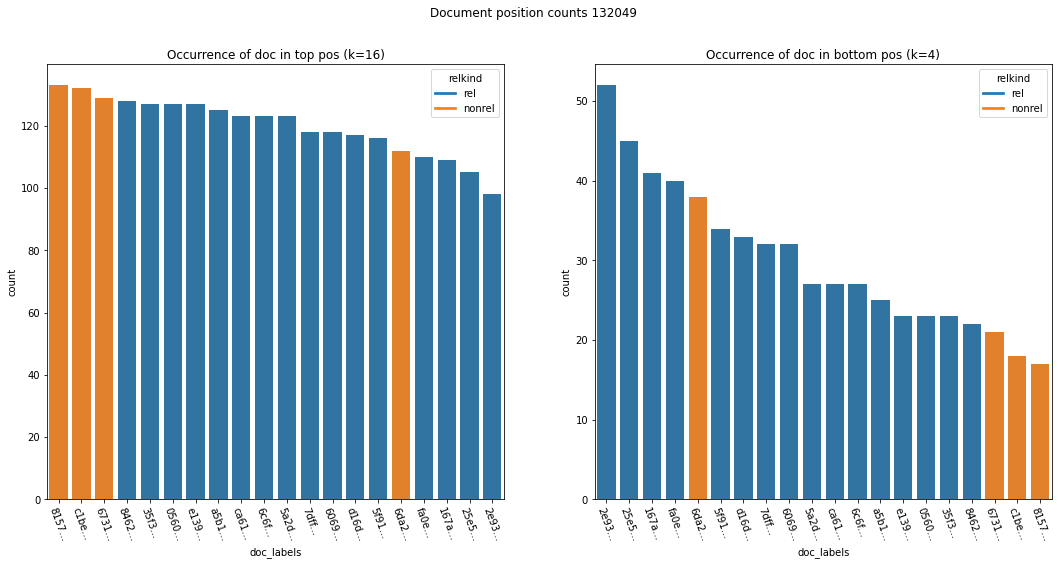

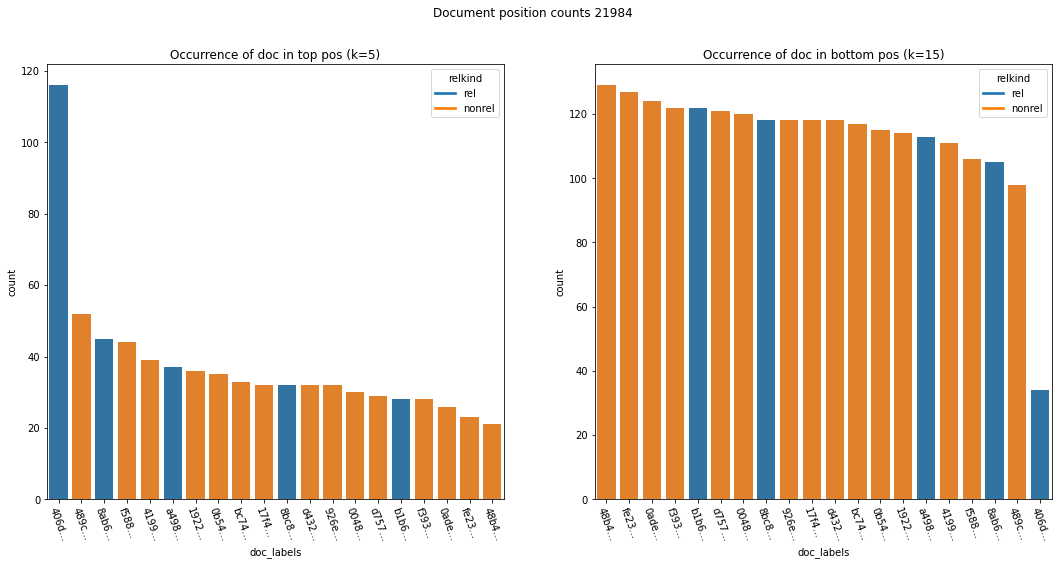

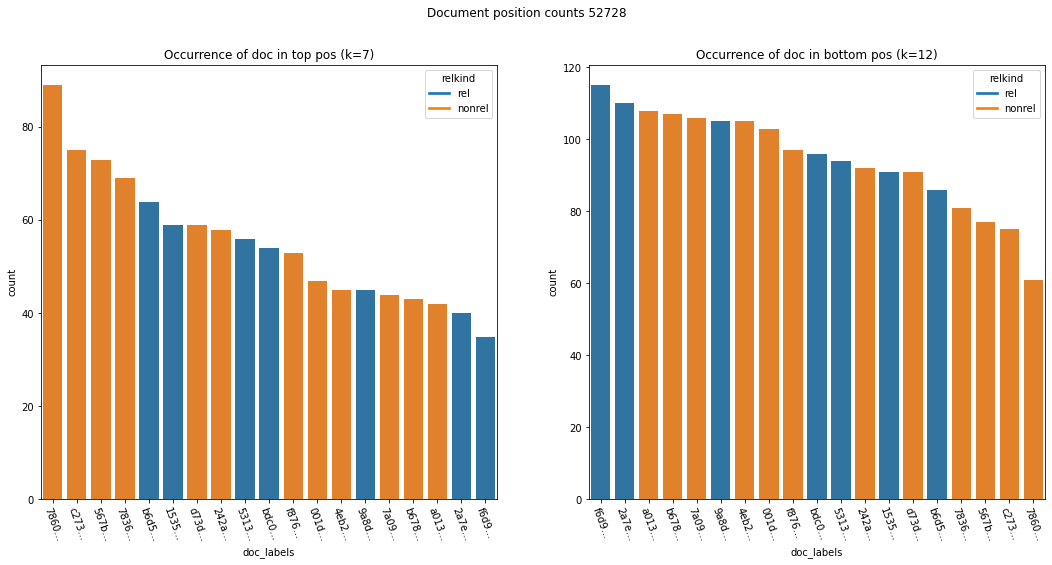

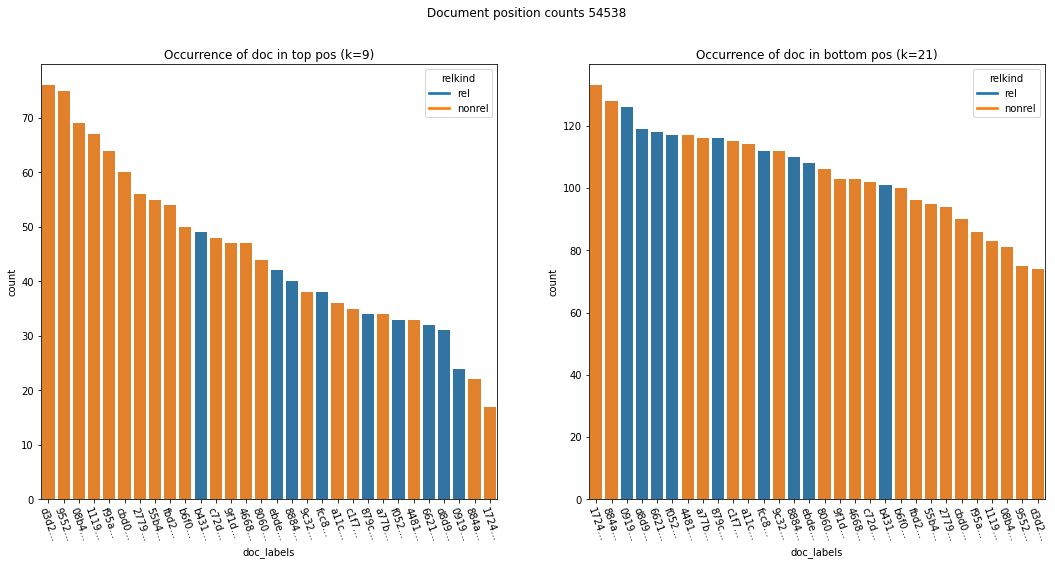

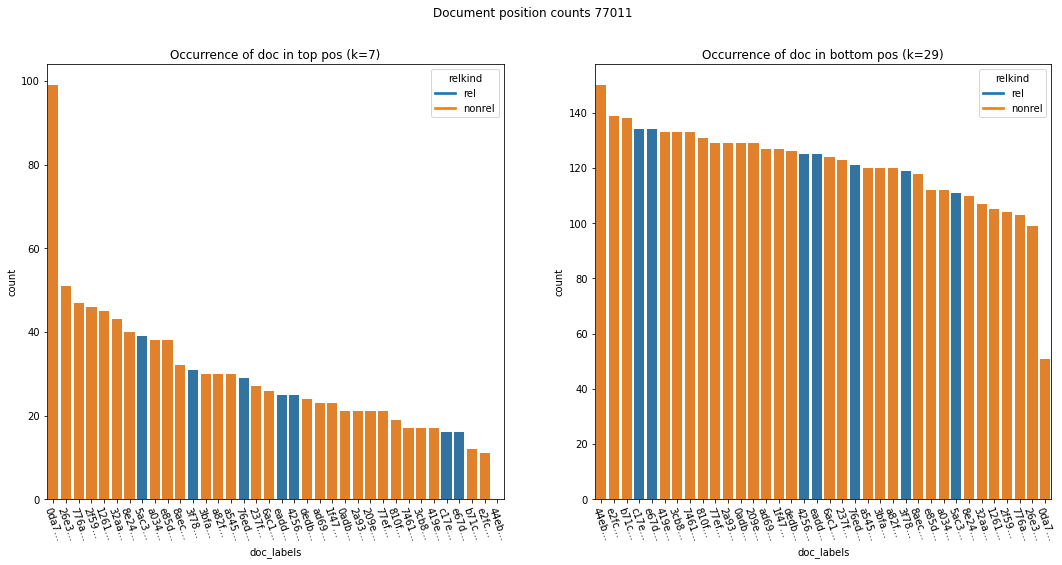

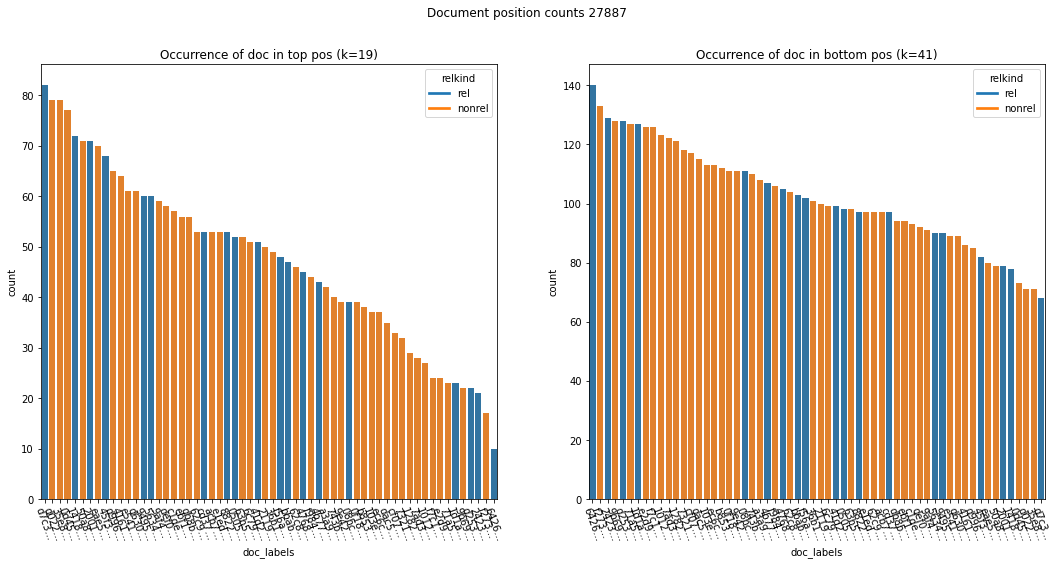

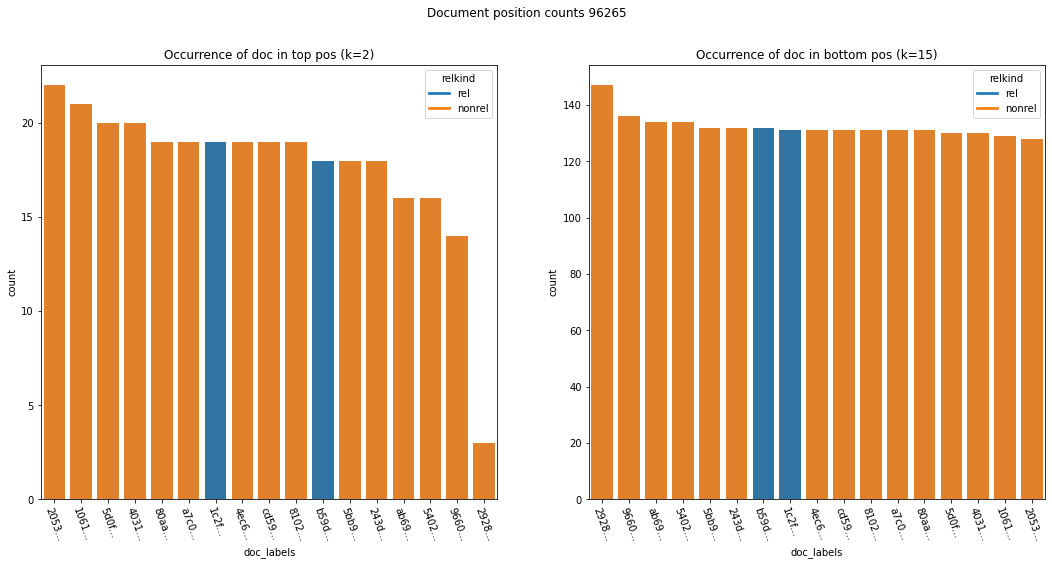

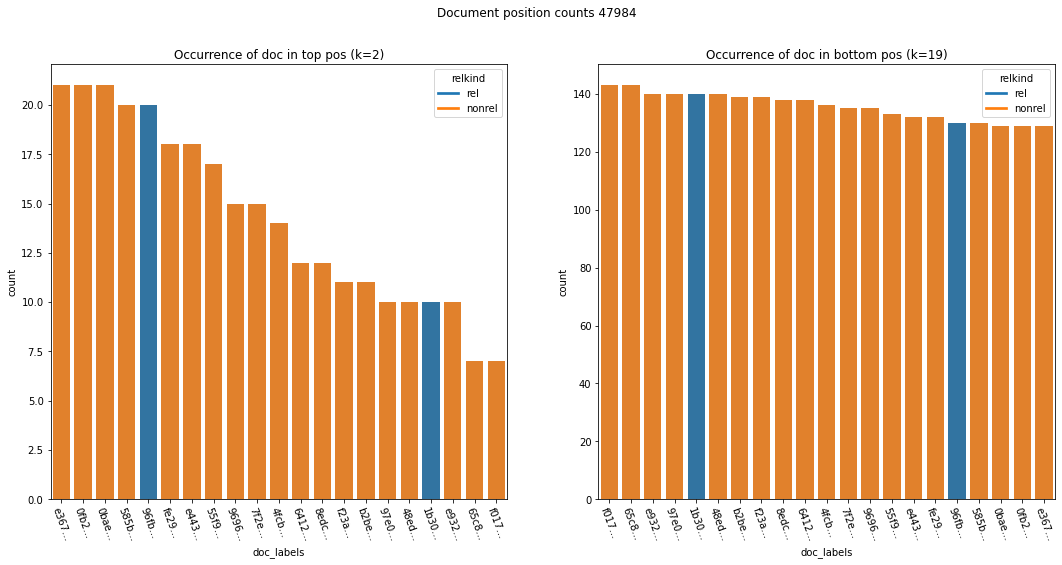

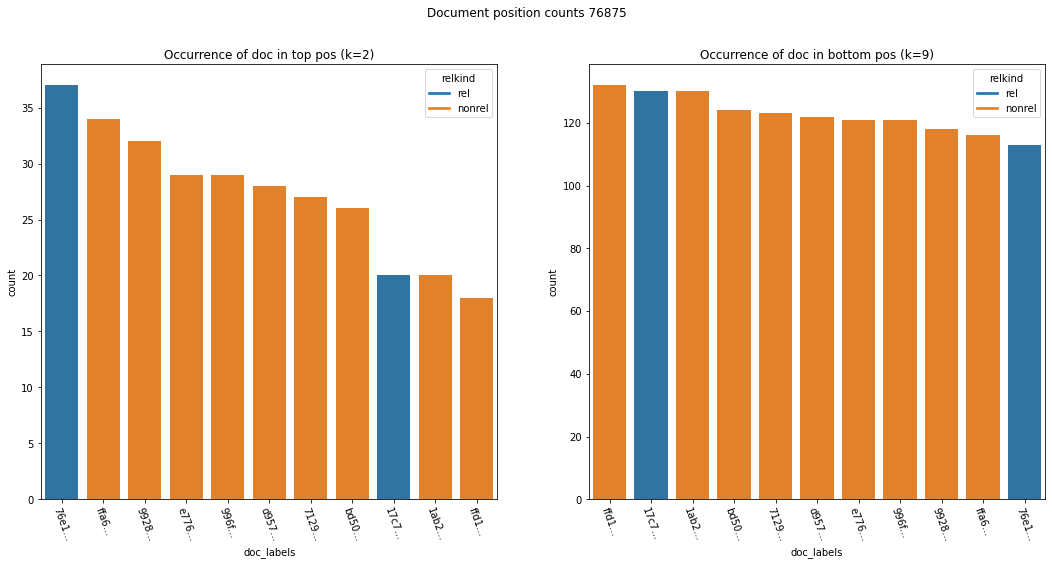

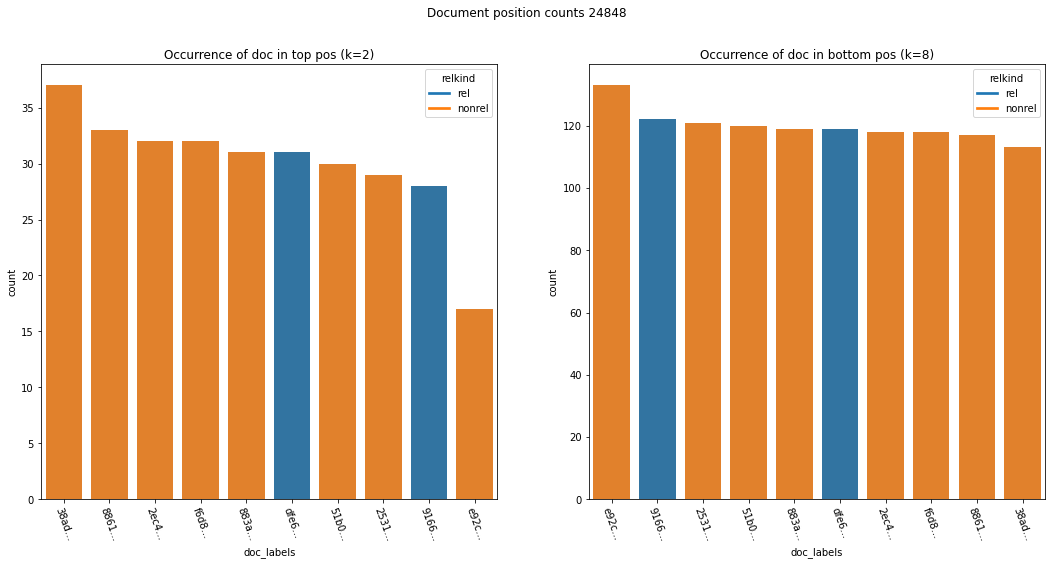

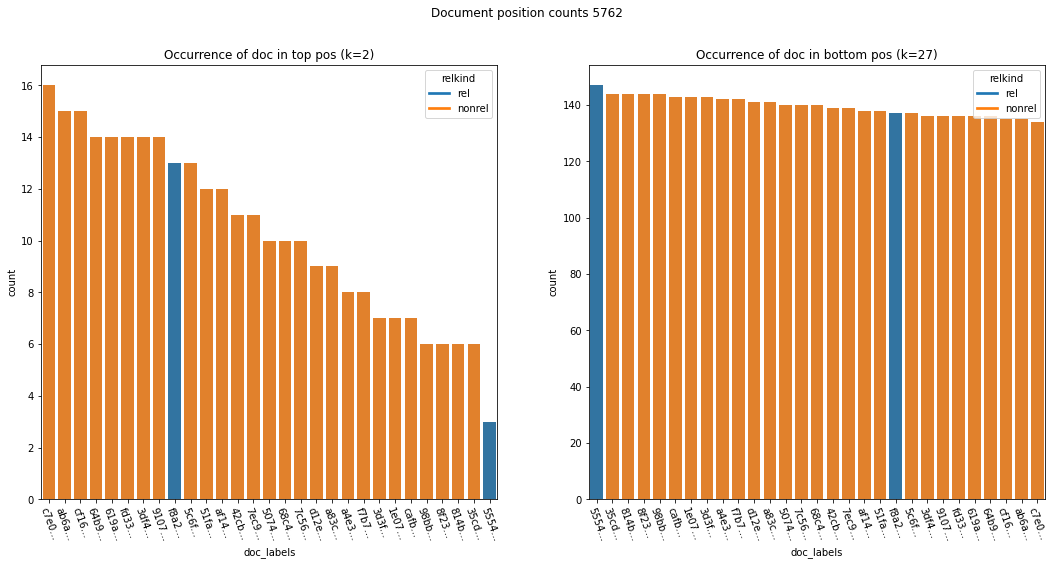

In [115]:
for q in inspectdf.qid.drop_duplicates().to_list():
        plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

#### Inspect documents of interest

##### Estimated relevances

In [116]:
inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
17,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top
29,45,25e5f01d3d4b05a01beaacf33c2c30628f0679ca,1,bot,132049,top
7,41,167abf8617dc3a30990addfcf6fb3161ff222f21,1,bot,132049,top
31,40,fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a,1,bot,132049,top
39,122,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,bot,21984,top
1,115,f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c,1,bot,52728,top
3,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top
15,126,091904c2b9d8ef6fe127b97d461c8e51d20237be,1,bot,54538,top
17,119,d8d969c4c74f2759e0eccd9fd5b6b775036650f1,1,bot,54538,top
3,118,6621f6f8087226645cc00120a9b14da4354518ca,1,bot,54538,top


In [117]:
inpspectdf_select = inspectdf[inspectdf.doc_id.isin(['2e93445410af33f0c377ed65bcc4ac74a8826ae2',
                                                     '2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb',
                                                    '6426c1444b4b397982ae1b8782dba53ad662fbeb',
                                                    '1b303e6f3e4213cccba4e08ac5e75b4c9790d213',
                                                    '17c780c1aca508a3172fa0d5dd1bf10168a10f54',
                                                    '55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144'])]
                              
inpspectdf_select

,count,doc_id,doc_rel,pos,qid,topbot
17,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top
3,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top
95,140,6426c1444b4b397982ae1b8782dba53ad662fbeb,1,bot,27887,top
29,140,1b303e6f3e4213cccba4e08ac5e75b4c9790d213,1,bot,47984,bot
19,130,17c780c1aca508a3172fa0d5dd1bf10168a10f54,1,bot,76875,bot
51,147,55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144,1,bot,5762,bot


In [118]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels

,count,doc_id,relevance,pos,qid,topbot,est_relevance
0,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top,0.187206
1,45,25e5f01d3d4b05a01beaacf33c2c30628f0679ca,1,bot,132049,top,0.179613
2,41,167abf8617dc3a30990addfcf6fb3161ff222f21,1,bot,132049,top,0.187206
3,40,fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a,1,bot,132049,top,0.179613
4,122,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,bot,21984,top,0.067000
5,115,f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c,1,bot,52728,top,0.236089
6,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top,0.233840
7,126,091904c2b9d8ef6fe127b97d461c8e51d20237be,1,bot,54538,top,0.199217
8,119,d8d969c4c74f2759e0eccd9fd5b6b775036650f1,1,bot,54538,top,0.191665
9,118,6621f6f8087226645cc00120a9b14da4354518ca,1,bot,54538,top,0.248919


In [119]:
inspectrels.est_relevance.mean()

0.18333806712472892

In [120]:
inspectrels.est_relevance.min()

0.0669999602274531

In [121]:
inspectrels.est_relevance.max()

0.25621193351684

In [122]:
inspectrels[inspectrels.topbot=='top'].est_relevance.mean()

0.19848138036106452

In [123]:
inspectrels[inspectrels.topbot=='top'].est_relevance.min()

0.0669999602274531

In [124]:
inspectrels[inspectrels.topbot=='top'].est_relevance.max()

0.25621193351684

In [125]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.mean()

0.11140732925213481

In [126]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.min()

0.0766392048464476

In [127]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.max()

0.16352391775566502

In [128]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 2e93445410af33f0c377ed65bcc4ac74a8826ae2 	 top 	 0.187206085519219
132049 	 25e5f01d3d4b05a01beaacf33c2c30628f0679ca 	 top 	 0.179613166813848
132049 	 167abf8617dc3a30990addfcf6fb3161ff222f21 	 top 	 0.187206085519219
132049 	 fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a 	 top 	 0.179613166813848
21984 	 b1b68f721e5126c4f1c1cc7c0bbc91071eaac222 	 top 	 0.0669999602274531
52728 	 f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c 	 top 	 0.236088575157381
52728 	 2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb 	 top 	 0.233839881533441
54538 	 091904c2b9d8ef6fe127b97d461c8e51d20237be 	 top 	 0.19921712924843402
54538 	 d8d969c4c74f2759e0eccd9fd5b6b775036650f1 	 top 	 0.191665177636188
54538 	 6621f6f8087226645cc00120a9b14da4354518ca 	 top 	 0.24891895317031898
54538 	 f0524d5c84f237d57c4a1071bd9dc52e701feb05 	 top 	 0.24891895317031898
54538 	 879c8af3f0aca90e17e4008b7c914438bbee3495 	 top 	 0.20163352601981896
77011 	 c17e5dc7ec9a75f04fe52743d87fea0eb00246b2 	 top 	 0.184173427469443
77011 	 e67d

In [129]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 2e93445410af33f0c377ed65bcc4ac74a8826ae2 	 top 	 0.187206085519219
132049 	 25e5f01d3d4b05a01beaacf33c2c30628f0679ca 	 top 	 0.179613166813848
132049 	 167abf8617dc3a30990addfcf6fb3161ff222f21 	 top 	 0.187206085519219
132049 	 fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a 	 top 	 0.179613166813848
21984 	 b1b68f721e5126c4f1c1cc7c0bbc91071eaac222 	 top 	 0.0669999602274531
52728 	 f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c 	 top 	 0.236088575157381
52728 	 2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb 	 top 	 0.233839881533441
54538 	 091904c2b9d8ef6fe127b97d461c8e51d20237be 	 top 	 0.19921712924843402
54538 	 d8d969c4c74f2759e0eccd9fd5b6b775036650f1 	 top 	 0.191665177636188
54538 	 6621f6f8087226645cc00120a9b14da4354518ca 	 top 	 0.24891895317031898
54538 	 f0524d5c84f237d57c4a1071bd9dc52e701feb05 	 top 	 0.24891895317031898
54538 	 879c8af3f0aca90e17e4008b7c914438bbee3495 	 top 	 0.20163352601981896
77011 	 c17e5dc7ec9a75f04fe52743d87fea0eb00246b2 	 top 	 0.184173427469443
77011 	 e67d

In [130]:
est_rel_meta.head()

,qid,doc_id,relevance,est_relevance
0,5438,3e19046c665867bbe557685da60738a40738010a,0,0.179419
1,5438,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0,0.145612
2,5438,ec13c3e7119191802e6f5783d297fe7a5a05293e,0,0.210751
3,5438,8fc928bb430d3f72ac876ca156042ad1860acacd,0,0.079591
4,5438,b2fdee22aa02477292b858fbafcb418932732bce,1,0.260175


In [131]:
inspectdf

,count,doc_id,doc_rel,pos,qid,topbot
17,52,2e93445410af33f0c377ed65bcc4ac74a8826ae2,1,bot,132049,top
29,45,25e5f01d3d4b05a01beaacf33c2c30628f0679ca,1,bot,132049,top
7,41,167abf8617dc3a30990addfcf6fb3161ff222f21,1,bot,132049,top
31,40,fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a,1,bot,132049,top
39,122,b1b68f721e5126c4f1c1cc7c0bbc91071eaac222,1,bot,21984,top
1,115,f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c,1,bot,52728,top
3,110,2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb,1,bot,52728,top
15,126,091904c2b9d8ef6fe127b97d461c8e51d20237be,1,bot,54538,top
17,119,d8d969c4c74f2759e0eccd9fd5b6b775036650f1,1,bot,54538,top
3,118,6621f6f8087226645cc00120a9b14da4354518ca,1,bot,54538,top


In [132]:
edf.head(10).qid.to_list()

[132049, 71096, 15395, 21984, 52728, 54538, 35778, 77011, 27887, 96265]

In [133]:
edf.tail(10).qid.to_list()

[82759, 5762, 24848, 76875, 30631, 11856, 31412, 111469, 47984, 33337]

In [134]:
for q in inspectdf.qid.drop_duplicates().to_list():
    a = est_rel_meta[est_rel_meta.qid == q].sort_values(by=['qid','est_relevance'],ascending=False)
    a["inspect"] = False
    # print(a)
    a["inspect"] = a.apply(lambda row: row.doc_id in inspectdf[inspectdf.qid == q].doc_id.to_list(),axis=1)
    print(a[['qid','doc_id','est_relevance','inspect']])

         qid                                    doc_id  est_relevance  inspect
2603  132049  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6       0.198229    False
2587  132049  6c6fc8896569067cf30b0f2349933c7462809912       0.187206    False
2589  132049  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4       0.187206    False
2590  132049  167abf8617dc3a30990addfcf6fb3161ff222f21       0.187206     True
2592  132049  5a2de88464b2307f1fd89f3d84c6d507a49cb47f       0.187206    False
2595  132049  7dff8a6d32efbaa16fb7510b9c3347985de71596       0.187206    False
2597  132049  a5b1fe9129df3f499eeeb7c30913109e448a1174       0.187206    False
2598  132049  ca614b83b9496ef4893881a713195c5389c19ec8       0.187206    False
2599  132049  2e93445410af33f0c377ed65bcc4ac74a8826ae2       0.187206     True
2586  132049  d16d4ab632d18d70c0ffd9d4d7493444281275e5       0.179613    False
2588  132049  e13918f61745d29a2e84101ebfc46e9487d38fca       0.179613    False
2593  132049  35f38d22d658330d980eb78f4774ad1a68a11e

In [135]:
est_rel_meta[(est_rel_meta.qid == 5762)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
1733,5762,cafb96b11ae8e8cd5e3171fcbdba68efa1176535,0,0.072707
1748,5762,35cddfed05641142f55d82da6dc24985ab6dc720,0,0.073544
1752,5762,814bda29b30e3c67bf61c7aac5ef508f7d943630,0,0.074477
1734,5762,55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144,1,0.076639
1736,5762,8f232e7b24d03b299ef1dc99ef5ed532c843308e,0,0.085570
1757,5762,98bb60748eb8ef7a671cdd22faa87e377fd13060,0,0.090166
1753,5762,1e077413b25c4d34945cc2707e17e46ed4fe784a,0,0.091364
1749,5762,f7b749f92f31cccc4e176bb93469f596f01a7d6e,0,0.092370
1741,5762,3d3f789a56dca288b2c8e23ef047a2b342184950,0,0.095002
1739,5762,a83cec6a91701bd8500f8c43ad731d4353c71d55,0,0.103799


In [136]:
est_rel_meta[(est_rel_meta.qid == 52728)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
2340,52728,78600073012747814a2293cceb58658df5ca3899,0,0.067842
2350,52728,567ba4bdc6dabcc6a0dd9fb68899f7edb6d4238b,0,0.071045
2342,52728,bdc09e28ce331b8a5f78310b7c644b0485cd300e,1,0.093680
2352,52728,f876d010f07d87c1b5da2a0e97be6e871e5dbd77,0,0.101581
2349,52728,c273cb0fcab40abe02805c689806f59c50b7d640,0,0.106872
2347,52728,b6d58f6d006acfe4df4e4b0e30f5c070738fba5b,1,0.136974
2355,52728,001d90376ea9a5672e6a2b37ff468d6f3ee0a3e5,0,0.150015
2348,52728,242a976b17f8005f91a2f7aacbb85bf7d6424426,0,0.151359
2337,52728,78360444f3b4540339efc9e7e5f2610a7e46c023,0,0.152619
2343,52728,7a0966ce97904ecf8c89eeedab8f90abea965ce5,0,0.166938


In [137]:
est_rel_meta[(est_rel_meta.qid == 54538)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance
952,54538,111946b1e82eb6d362026726e18a1083129bfc61,0,0.070979
966,54538,55b435376e2e2ebd5b0752d819732dbd4149aed9,0,0.073626
978,54538,cbd0e4517d81182aa07830e93cd8ecc05cf2ff81,0,0.074993
974,54538,9552c0890230f5f2191e06e7457ef05ca7fc5d56,0,0.075727
979,54538,08b4ef64497107c71553f163ecf880f6d1a53a5d,0,0.086176
972,54538,c72dbf820d2ee8d3cea40d15437d5c1b273e0006,0,0.088853
951,54538,f95a2a61f545e731b5637708221d5c360ad272e1,0,0.096779
954,54538,2779def3b6e5ff2a03baa06f9b70c42cfe70d95b,0,0.097261
960,54538,d3d2047b64752b0f7faffaf51084fb5c0212d54f,0,0.115732
964,54538,8060ae82b88c7170816f52c081c48c18d6bc31a3,0,0.118370


In [138]:
est_rel_meta[(est_rel_meta.qid == 277887)].sort_values(by='est_relevance')

,qid,doc_id,relevance,est_relevance


#### Authors

In [139]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [140]:
no_author

[]

In [141]:
res

{'took': 9900,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 23, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '6621f6f8087226645cc00120a9b14da4354518ca',
    '_score': 1.0,
    '_source': {'title': 'Influence of violent media on children and adolescents',
     'paperAbstract': 'In their review on the influence of violent media on children and adolescents, Kevin Browne and Catherine HamiltonGiachritsis (Feb 19, p 702) raise the question of why children and adolescents are more susceptible to media violence than adults. The effects of television are best understood in terms of rote learning—ie, by the brain digesting thousands of examples and thereby shaping synaptic connections, a process usually referred to as neuroplasticity. Lundborg and Rosén made the link between age and the speed of synaptic change quite clear. They plotted the resu

## 4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty, as measured by DGEE?

In [142]:
edf = edf.sort_values(by='difference')
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137


In [143]:
dif_disp_rel = edf.reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
concatenated.head()


key,difficulty,value,metric
0,0,1.421254,disparity
1,1,1.974314,disparity
2,2,2.044128,disparity
3,3,1.441575,disparity
4,4,1.029654,disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

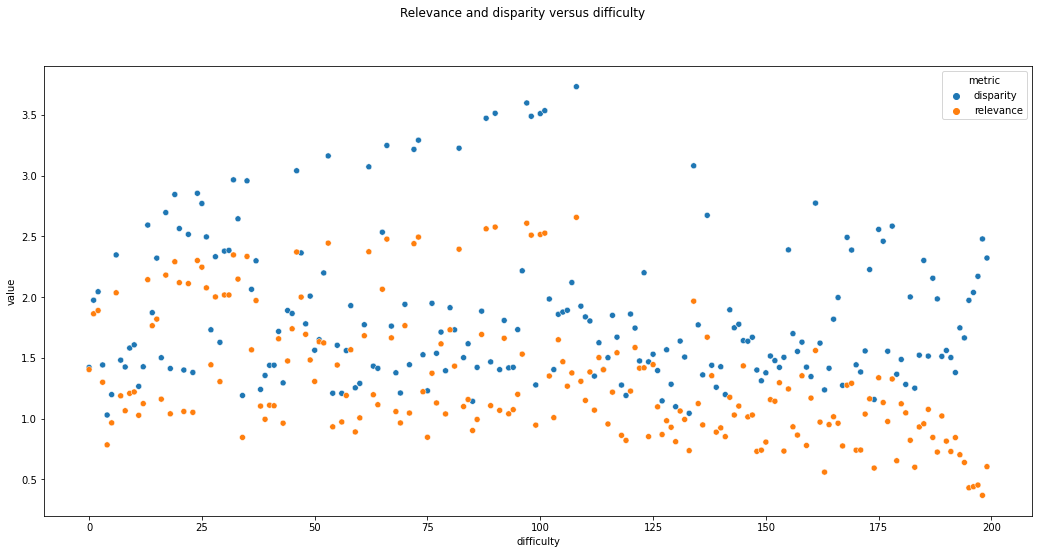

In [144]:
fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

# Old

## Hypotheses

Based on the plots we form a number of hypotheses:

1. Queries perform well when they have a high fraction of relevant items.
2. Queries perform well when they have a large number of items.
3. Queries perform poorly when they have many documents without author.
 - Conversely: queries perform well when they have many many documents without author, because then the ranking is more or less relevance-based.

4. All of the documents that spike in the rankings have no author.
5. Documents that are missing from their "proper" position (mainly relevant documents for top positions) have a low estimated relevance.



6. Documents for which the estimated relevance is too high/too low have been incorrectly judged by the NIST assessors.



7. For top queries, the documents without author are mainly relevant. For bottom queries, they are mainly irrelevant.

check:
- for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    

### Hypothesis 1: Queries perform well when they have a high fraction of relevant items

In [145]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [146]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

In [147]:
print("DGEE > mean:\t", len(edf[edf.difference > edf.difference.mean()]))
print()
print("DGEE <= mean:\t", len(edf[edf.difference <= edf.difference.mean()]))

DGEE > mean:	 66

DGEE <= mean:	 134


Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [148]:
top = rel_nonrel_stats_df(edf, k=len(edf[edf.difference <= edf.difference.mean()]))
bot = rel_nonrel_stats_df(edf, k=len(edf[edf.difference > edf.difference.mean()]), asc=False)

print("topqueries relmean:\t", top.rfrac.mean(),'\t',"botqueries relmean:\t\t", bot.rfrac.mean())
print("topqueries non-relmean:\t", top.nrfrac.mean(),'\t',"botqueries non-relmean:\t",bot.nrfrac.mean())


topqueries relmean:	 0.17619605519349074 	 botqueries relmean:		 0.15684223769691605
topqueries non-relmean:	 0.8238039448065092 	 botqueries non-relmean:	 0.843157762303084


The effect is even more clear if we look at the top and bottom 20 queries.

In [149]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print("topk=20 relmean:\t",top.rfrac.mean(),'\tbotk=20 relmean:\t',bot.rfrac.mean())
print("topk=20 nrelmean:\t",top.nrfrac.mean(),'\tbotk=20 nrelmean:\t',bot.nrfrac.mean())


topk=20 relmean:	 0.2201941158259358 	botk=20 relmean:	 0.14473343582035553
topk=20 nrelmean:	 0.7798058841740643 	botk=20 nrelmean:	 0.8552665641796443


In [150]:
for i in range(1,21):
    top = rel_nonrel_stats_df(edf,k=i)
    bot = rel_nonrel_stats_df(edf,k=i,asc=False)
    print(f"k={i}")
    print(f"top r:\t",round(top.rfrac.mean(),2),f'\tbot r:\t',round(bot.rfrac.mean(),2))
    print(f"top nr:\t",round(top.nrfrac.mean(),2),f'\tbot nr:\t',round(bot.nrfrac.mean(),2))
    print()

k=1
top r:	 0.2 	bot r:	 0.94
top nr:	 0.8 	bot nr:	 0.06

k=2
top r:	 0.46 	bot r:	 0.08
top nr:	 0.54 	bot nr:	 0.92

k=3
top r:	 0.36 	bot r:	 0.09
top nr:	 0.64 	bot nr:	 0.91

k=4
top r:	 0.33 	bot r:	 0.09
top nr:	 0.67 	bot nr:	 0.91

k=5
top r:	 0.34 	bot r:	 0.09
top nr:	 0.66 	bot nr:	 0.91

k=6
top r:	 0.33 	bot r:	 0.09
top nr:	 0.67 	bot nr:	 0.91

k=7
top r:	 0.31 	bot r:	 0.1
top nr:	 0.69 	bot nr:	 0.9

k=8
top r:	 0.3 	bot r:	 0.11
top nr:	 0.7 	bot nr:	 0.89

k=9
top r:	 0.3 	bot r:	 0.11
top nr:	 0.7 	bot nr:	 0.89

k=10
top r:	 0.28 	bot r:	 0.11
top nr:	 0.72 	bot nr:	 0.89

k=11
top r:	 0.26 	bot r:	 0.11
top nr:	 0.74 	bot nr:	 0.89

k=12
top r:	 0.25 	bot r:	 0.11
top nr:	 0.75 	bot nr:	 0.89

k=13
top r:	 0.24 	bot r:	 0.12
top nr:	 0.76 	bot nr:	 0.88

k=14
top r:	 0.23 	bot r:	 0.12
top nr:	 0.77 	bot nr:	 0.88

k=15
top r:	 0.23 	bot r:	 0.13
top nr:	 0.77 	bot nr:	 0.87

k=16
top r:	 0.24 	bot r:	 0.13
top nr:	 0.76 	bot nr:	 0.87

k=17
top r:	 0.23 	bot r:

In [151]:
data = rel_nonrel_stats_df(edf,k=200).reset_index()
data.head(5)

key,level_0,index,qid,difference,disparity,relevance,r,nr,rfrac,nrfrac
0,0,0,132049,0.002713,1.421254,1.403715,16,4,0.800000,0.200000
1,1,1,71096,0.027807,1.974314,1.862491,4,30,0.117647,0.882353
2,2,3,15395,0.033729,2.044128,1.889445,2,11,0.153846,0.846154
3,3,2,21984,0.051934,1.441575,1.299282,5,15,0.250000,0.750000
4,4,4,52728,0.078204,1.029654,0.784137,7,12,0.368421,0.631579


<AxesSubplot:xlabel='index', ylabel='rfrac'>

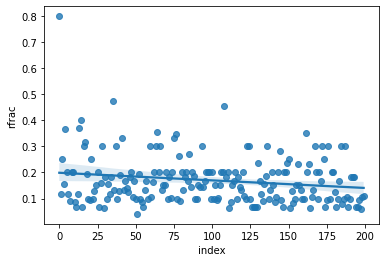

In [152]:
# sns.scatterplot(data=data, x="index", y="rfrac")
sns.regplot(data=data,x="index", y="rfrac")

We see a light descending line; the hypothesis is confirmed. The top queries have a higher fraction of relevant versus non-relevant items.

#### Subypothesis: The top queries have a higher average predicted relevance

- sum of estimated relevances for each relkind divided by number of items for that relkind

In [153]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

,index,qid,difference,disparity,relevance_x,doc_rel,doc_id,relevance_y,est_relevance,rel_estrel_diff
0,0,132049,0.002713,1.421254,1.403715,1,d16d4ab632d18d70c0ffd9d4d7493444281275e5,1,0.179613,0.820387
1,0,132049,0.002713,1.421254,1.403715,1,6c6fc8896569067cf30b0f2349933c7462809912,1,0.187206,0.812794
2,0,132049,0.002713,1.421254,1.403715,1,e13918f61745d29a2e84101ebfc46e9487d38fca,1,0.179613,0.820387
3,0,132049,0.002713,1.421254,1.403715,0,6da29e3f7e9ab2cbedccb71201ae62ed52f949a4,0,0.187206,0.187206
4,0,132049,0.002713,1.421254,1.403715,1,167abf8617dc3a30990addfcf6fb3161ff222f21,1,0.187206,0.812794


In [154]:
mean_estrel_per_relkind = rel_and_estrel.groupby(['qid','doc_rel']).mean().reset_index()
mean_estrel_per_relkind.head()

,qid,doc_rel,index,difference,disparity,relevance_x,relevance_y,est_relevance,rel_estrel_diff
0,69,0,53,0.178978,3.071752,2.372842,0,0.154769,0.154769
1,69,1,53,0.178978,3.071752,2.372842,1,0.131208,0.868792
2,258,0,146,0.514470,1.636991,1.014066,0,0.150459,0.150459
3,258,1,146,0.514470,1.636991,1.014066,1,0.206604,0.793396
4,439,0,141,0.486131,1.747236,1.029661,0,0.153111,0.153111


In [155]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
desired_index.head()

key,level_0,index,qid,difference,disparity,relevance
0,0,0,132049,0.002713,1.421254,1.403715
1,1,1,71096,0.027807,1.974314,1.862491
2,2,3,15395,0.033729,2.044128,1.889445
3,3,2,21984,0.051934,1.441575,1.299282
4,4,4,52728,0.078204,1.029654,0.784137


In [156]:
mean_estrel_with_index = pd.merge(mean_estrel_per_relkind,desired_index[['index','qid']],on='qid')
mean_estrel_with_index.head()

,qid,doc_rel,index_x,difference,disparity,relevance_x,relevance_y,est_relevance,rel_estrel_diff,index_y
0,69,0,53,0.178978,3.071752,2.372842,0,0.154769,0.154769,53
1,69,1,53,0.178978,3.071752,2.372842,1,0.131208,0.868792,53
2,258,0,146,0.514470,1.636991,1.014066,0,0.150459,0.150459,146
3,258,1,146,0.514470,1.636991,1.014066,1,0.206604,0.793396,146
4,439,0,141,0.486131,1.747236,1.029661,0,0.153111,0.153111,141


ValueError: Could not interpret value `index` for parameter `x`

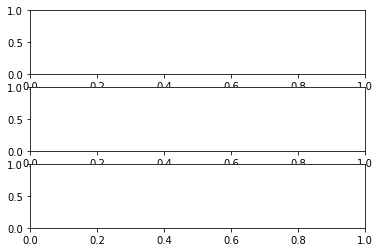

In [157]:
pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)
fig, ax = plt.subplots(3,1)
sns.scatterplot(data=mean_estrel_with_index,x='index',y='est_relevance',hue='doc_rel',ax= ax[0])
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 0],x='index',y='est_relevance',ax=ax[1],color=f)
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 1],x='index',y='est_relevance',ax=ax[2],color=s)

The top queries do *not* have a higher average predicted relevance than the bottom queries, so the discrepancy is likely *not* because of the estimated relevances.

#### Subhypothesis: The top queries have a higher fraction of items for which the actual and the predicted relevance are close to each other

Blur factor, fig 1 in [3], blur closer to true relevance is less unfairness compared to Plackett-Luce. May be because is better able to predict based on relevance also?

If the predicted relevances are closer to the actual relevances the ranker is better able to take relevance into account, leading to better results?

Plot: mean difference between predicted and actual relevances
Subplots: split by GT rel and nonrel items

In [ ]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

In [ ]:
mean_estrel_diff = rel_and_estrel.groupby('qid', as_index=False).mean()[['qid','difference','doc_rel','rel_estrel_diff']]
estrel_diff_sorted = mean_estrel_diff.sort_values(by='difference').reset_index(drop=True).reset_index()
estrel_diff_sorted.head()

In [ ]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
splitdata = rel_and_estrel.sort_values(by='difference').reset_index(drop=True)
splitdata = pd.merge(splitdata,desired_index[['qid','index']],on='qid')
splitdata.head()

In [ ]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
next(pi)
sns.scatterplot(data=estrel_diff_sorted,x='index',y='rel_estrel_diff',ax=ax,color=next(pi))
fig.suptitle("Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)")

In [ ]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 0],x='index',y='rel_estrel_diff', color=next(pi))
fig.suptitle('Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

In [ ]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 1],x='index',y='rel_estrel_diff')
fig.suptitle('Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

We see a couple of things:
1. The mean difference between estimated relevance and actual relevance is larger for the best queries. Contrary to our hypothesis.
2. For the non-relevant items, the difference in estimated and actual relevance is reasonably the same across all queries.
3. For the relevant items, we see a couple of outliers for which the difference is much larger than for the rest of the documents. 

#### To find out
- [ ] Which documents correspond to the outliers?
- [ ] What is their impact on the quality of the rankings?

### Hypothesis 2: Queries perform well when they have a large number of items
The thought being: many items give a chance for averaging out mistakes.

### Hypothesis 4: All of the documents that spike in the rankings have no author.

Show the documents without author in a different color.

In [193]:
def find_docs_without_author(relevance):
    es = Elasticsearch([{'timeout':300}])
    
    all_ids = list(relevance.doc_id.unique())
    res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
    returned_ids = [hit['_id'] for hit in res['hits']['hits']]
    not_in_index = list(set(all_ids) - set(returned_ids))
    no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
    no_author = list(set(not_in_index + no_author_in_idx))
    return no_author

In [194]:
def authorless_docs_from_mapping(mapping):
    return [k for k,v in mapping.items() if v == []]

In [195]:
def has_author_df(no_author_ids, relevance):
    relevance['has_author'] = relevance.apply(lambda row: row.doc_id not in no_author_ids,axis='columns')
    return relevance[['doc_id','has_author']].drop_duplicates()

In [196]:
noauth_ids = authorless_docs_from_mapping(doc_to_author)

In [197]:
author_info = has_author_df(noauth_ids,reldf)
author_info.head()

,doc_id,has_author
0,3e19046c665867bbe557685da60738a40738010a,True
0,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,True
0,ec13c3e7119191802e6f5783d297fe7a5a05293e,True
0,8fc928bb430d3f72ac876ca156042ad1860acacd,True
0,b2fdee22aa02477292b858fbafcb418932732bce,True


In [201]:
def get_docs_for_qid(qid):
    return est_rel_meta[est_rel_meta.qid == qid]

In [203]:
def es_search_docs(docids):
    return es.search(index='semanticscholar2020og', body={'size':len(docids), 'query':{'ids':{'values':docids}}})

In [205]:
get_docs_for_qid(111469)

,qid,doc_id,relevance,est_relevance
1283,111469,25c40e796680cdea53578dfad8c7bdbae7ee56a5,0,0.060952
1284,111469,647444c4963ddac18626a4d2817eb85e438405c0,1,0.161621
1285,111469,36dedcbd7ad1a9313b967e8e3b0dc0fa3df4f9ac,0,0.212803
1286,111469,ecf4c446122e770ca0d9031b9b8bdf7d6d40dc9b,0,0.097716
1287,111469,224289edb5ee14bbe960c061a58bd38adbf4f9d9,0,0.190947
1288,111469,4f940b31db19edda00bca85293093c779fa4dd5c,0,0.097344
1289,111469,3940e507cdf316b80e42504df02969e5449c925f,0,0.193124
1290,111469,34b6de1aee17441021e62b63c543abc1c28b0928,1,0.193041
1291,111469,e60af557a1bbfd9b2adee8a3c090d27faab86632,0,0.213855
1292,111469,c0fb289dbcbf888bc8ff96661bfcbda519625fac,0,0.190169


In [206]:
es_search_docs(['25c40e796680cdea53578dfad8c7bdbae7ee56a5'])

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

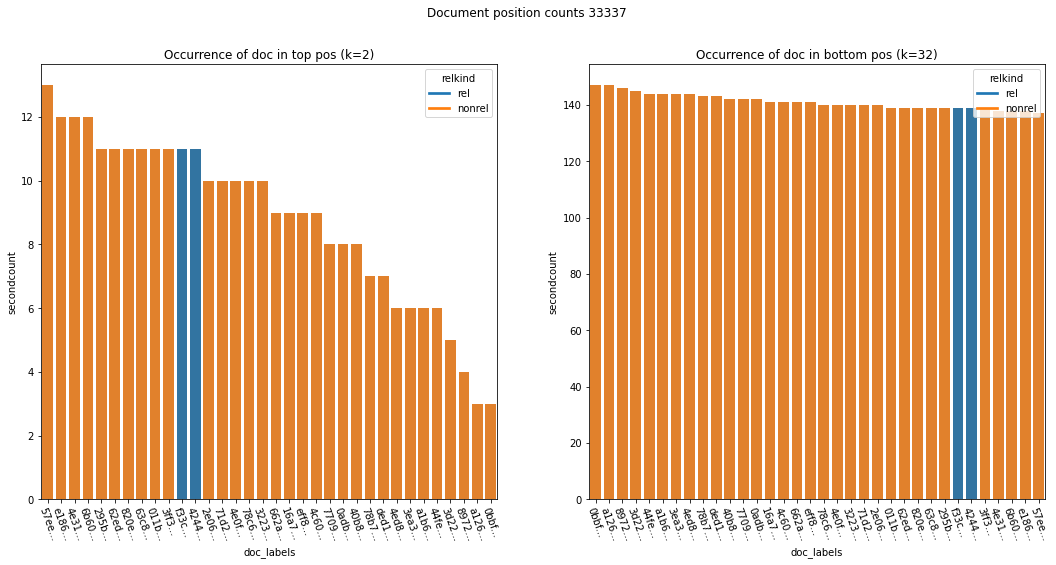

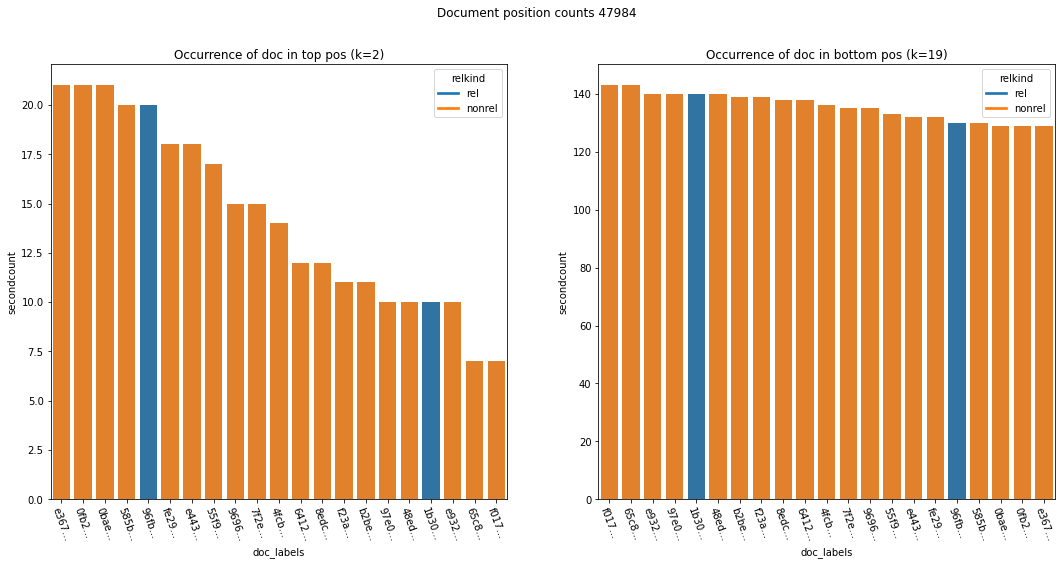

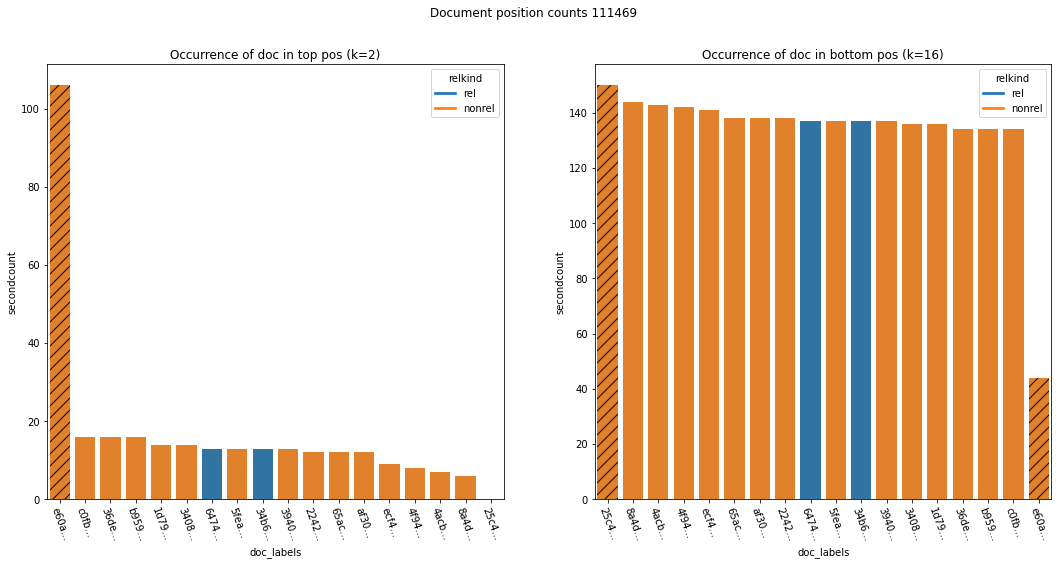

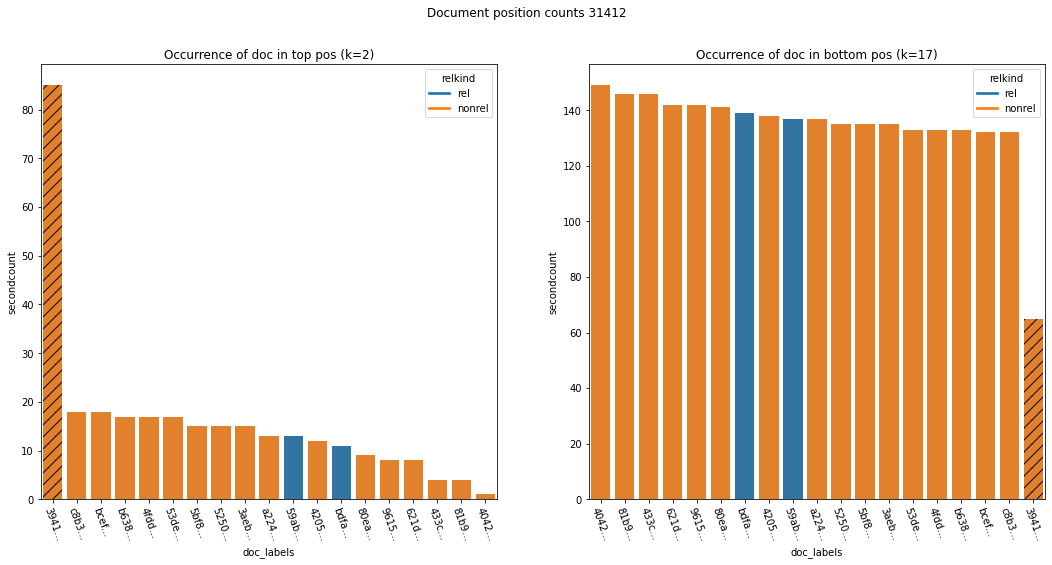

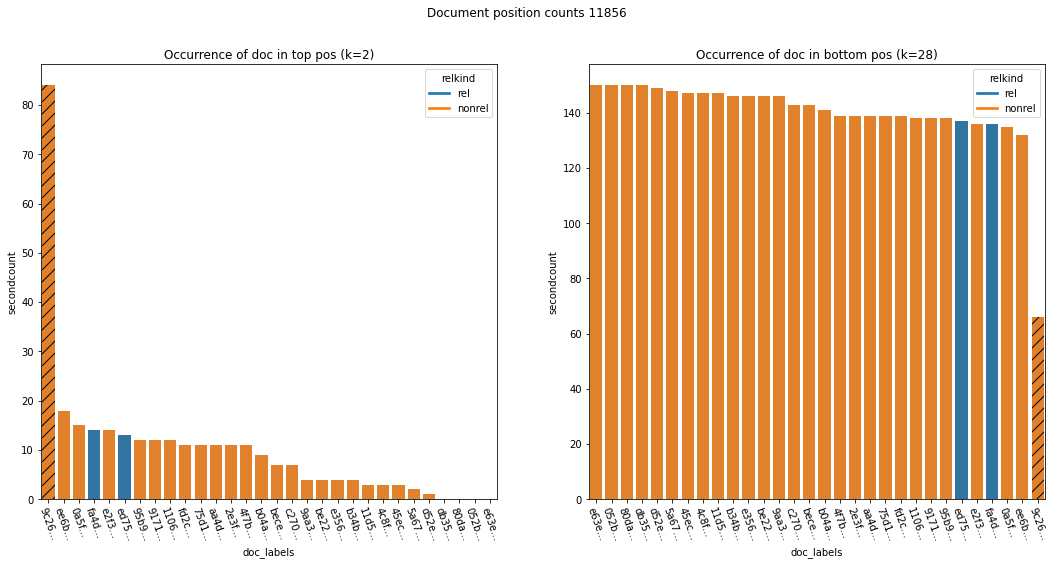

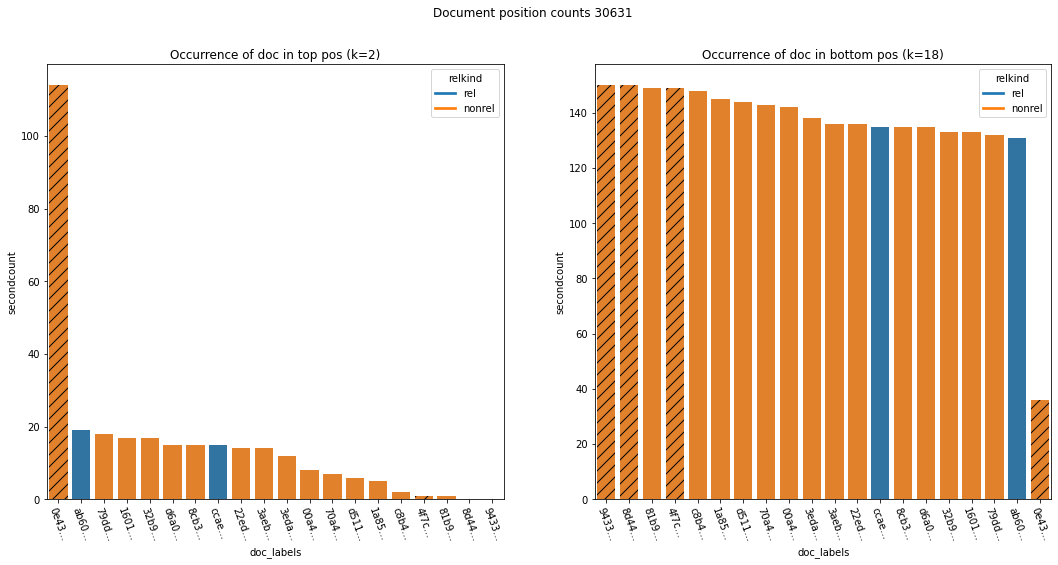

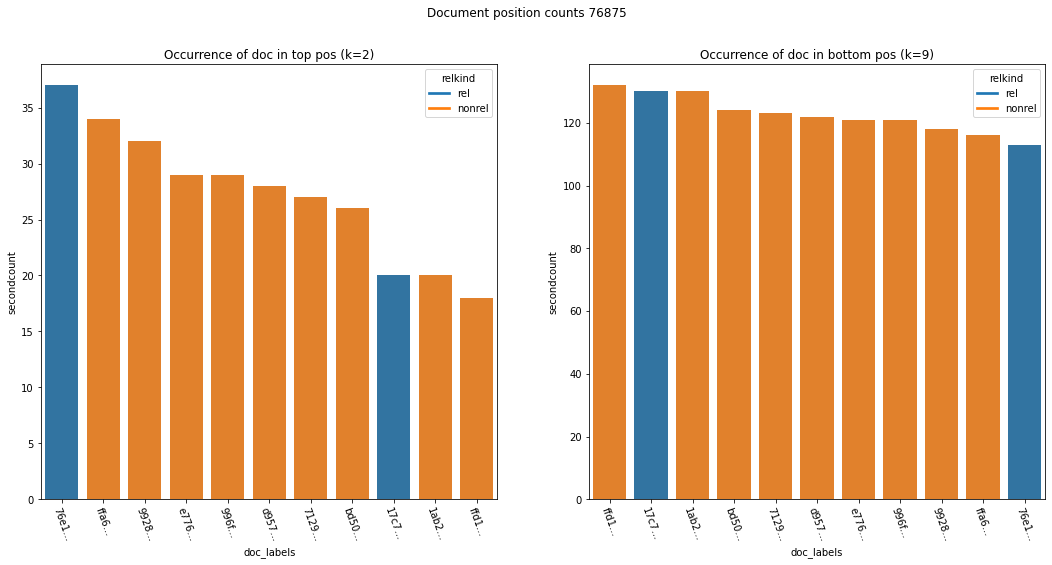

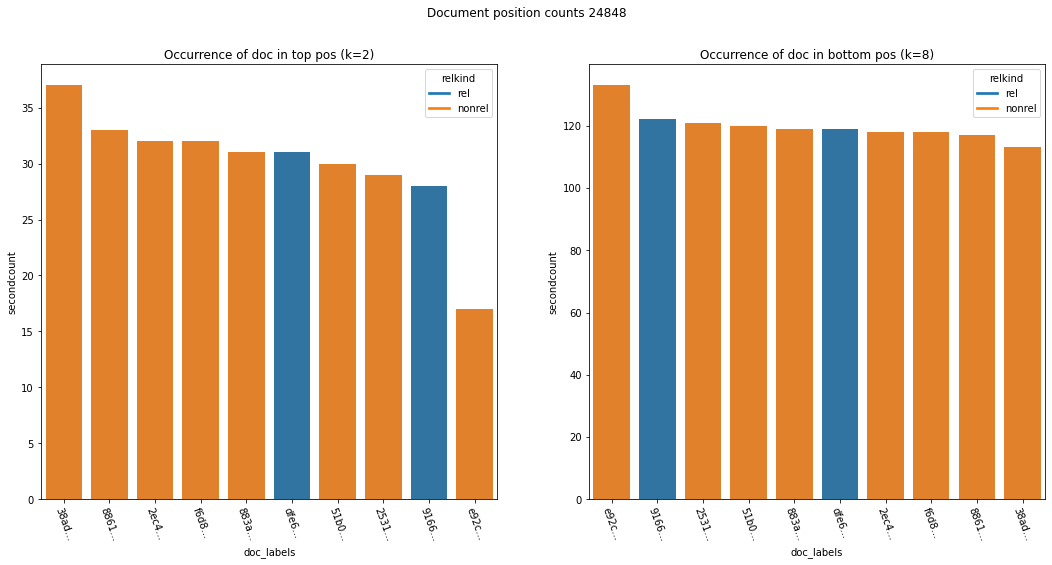

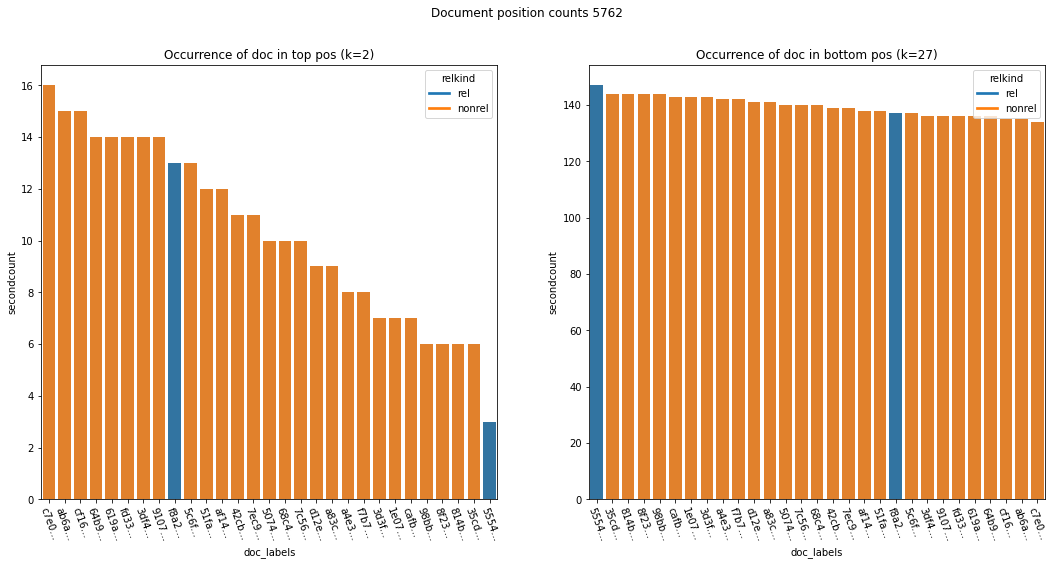

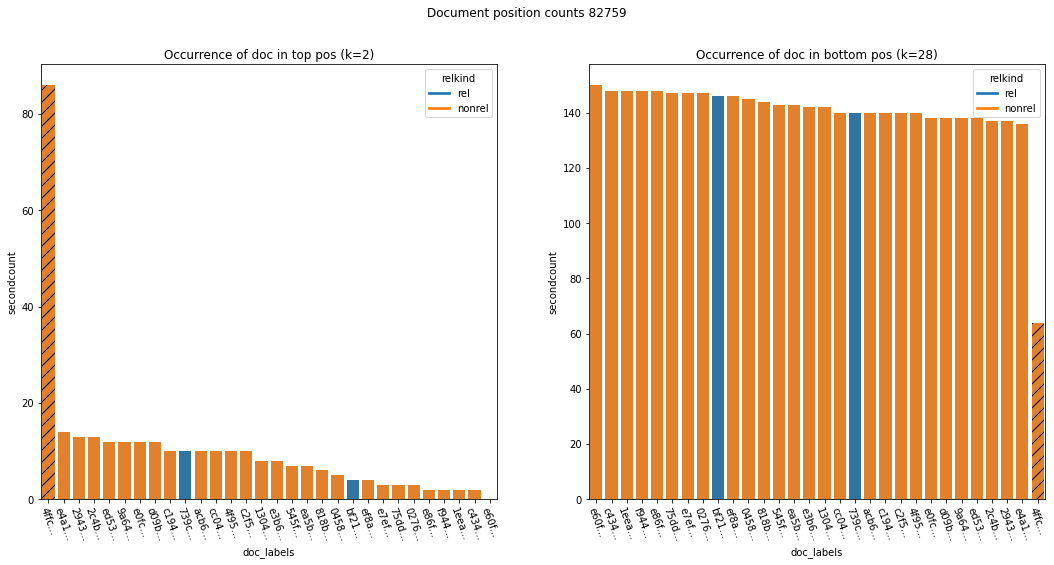

In [207]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,no_author_ids=noauth_ids)

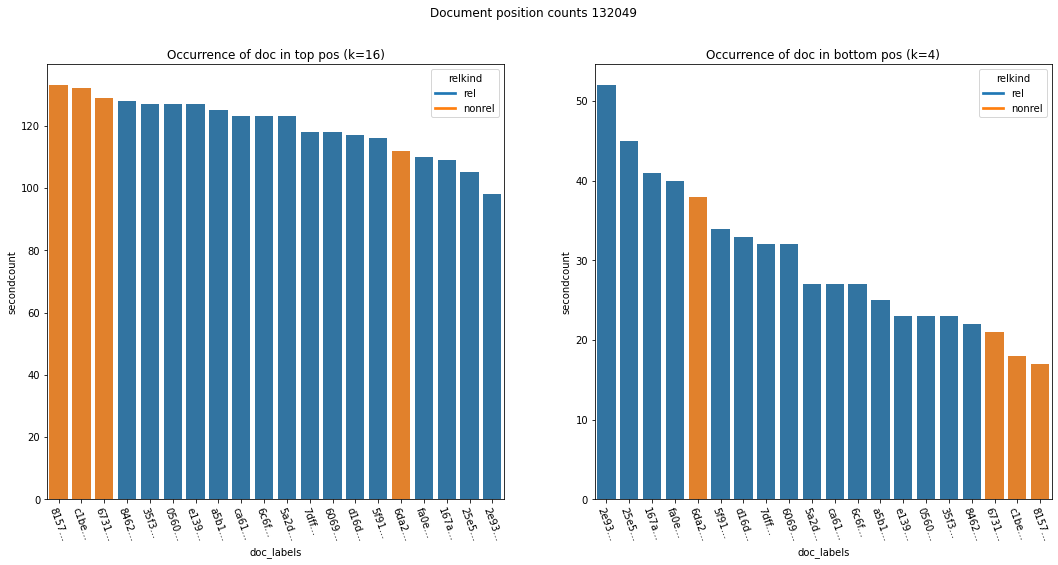

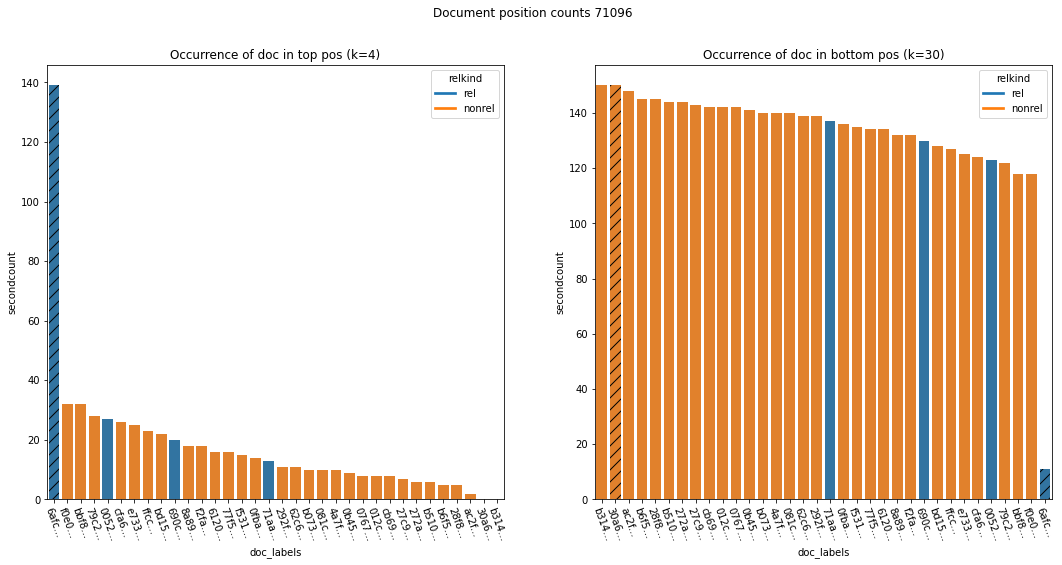

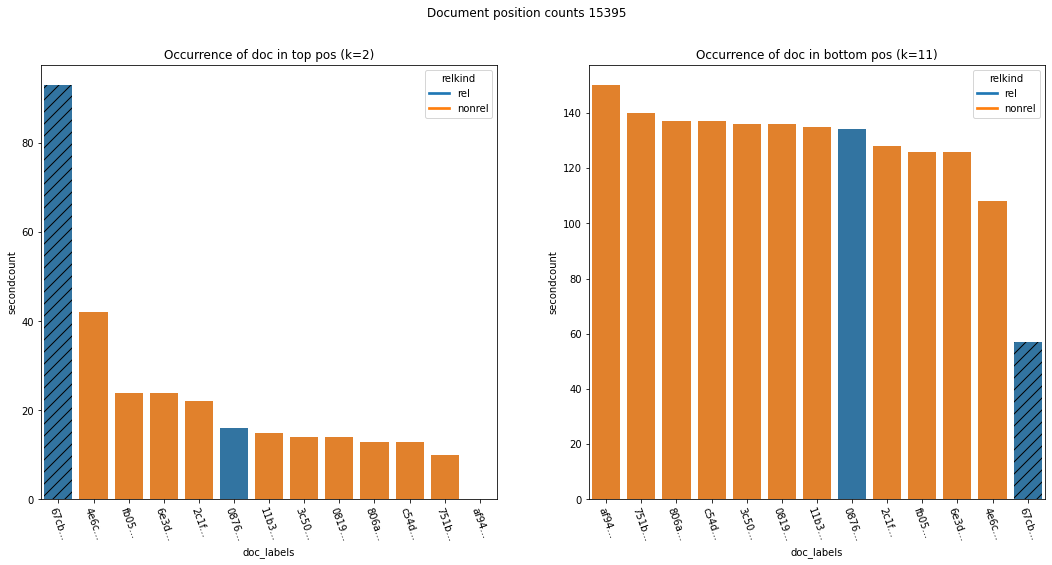

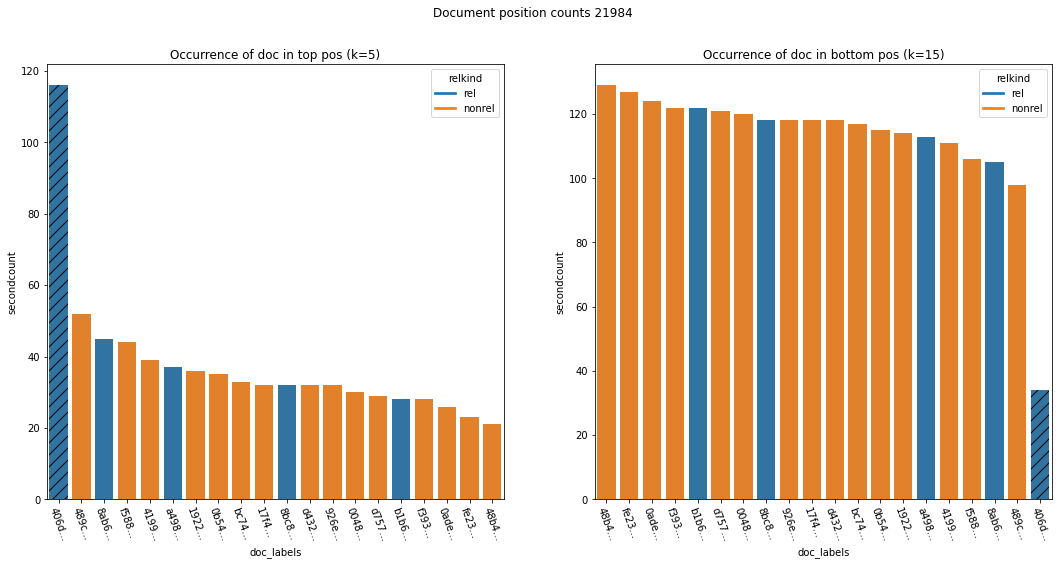

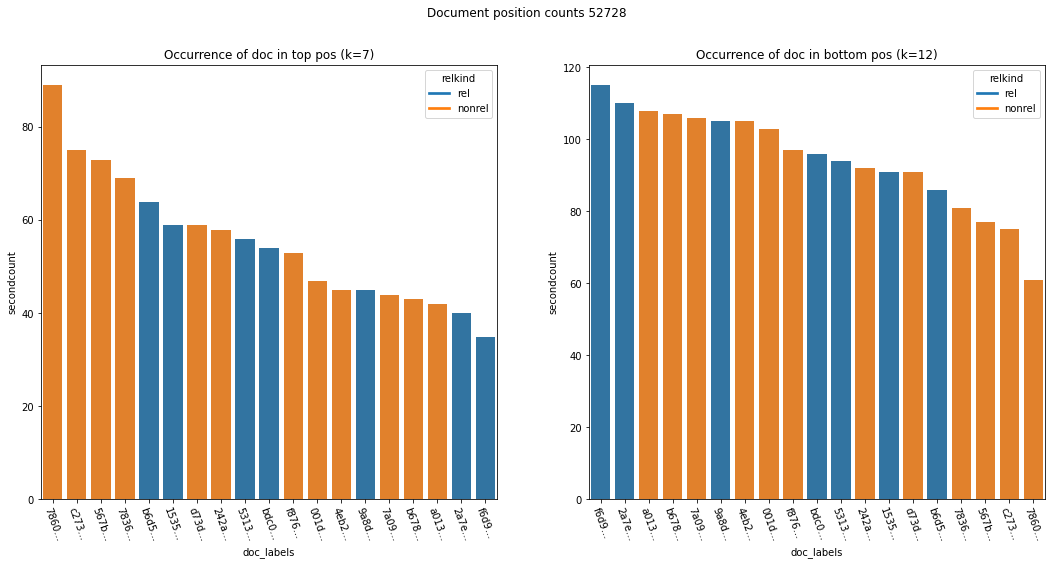

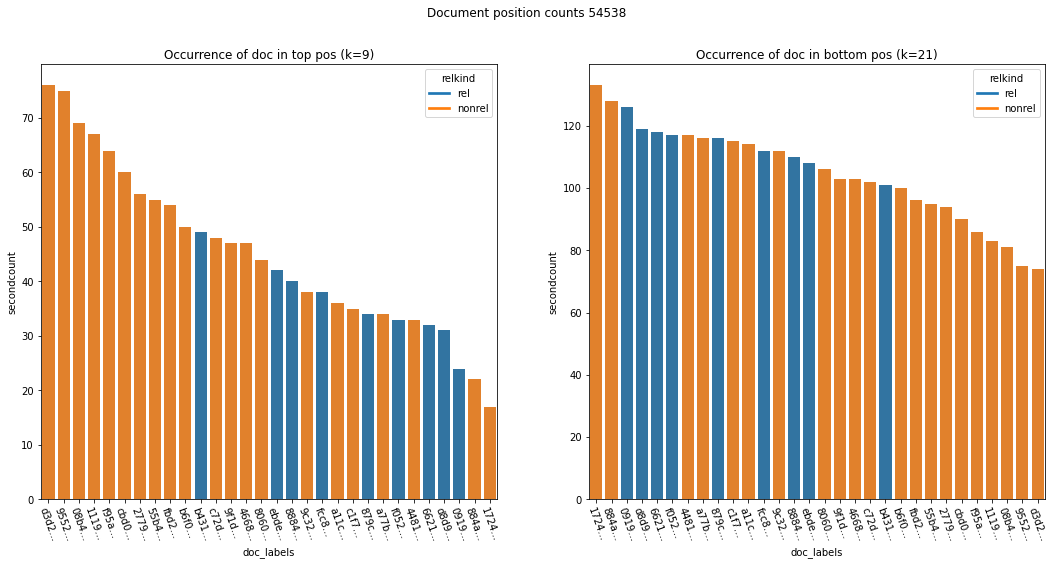

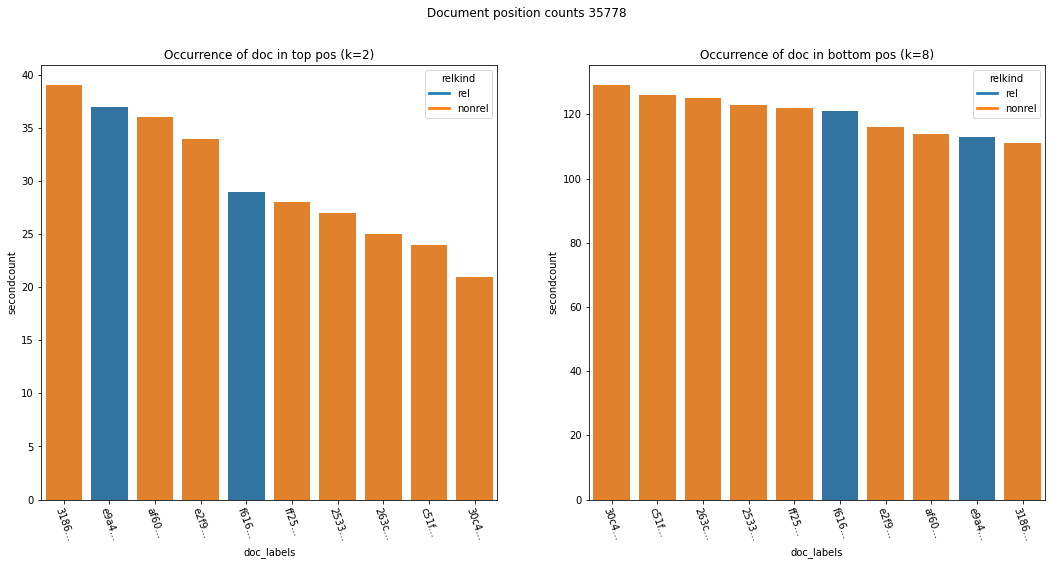

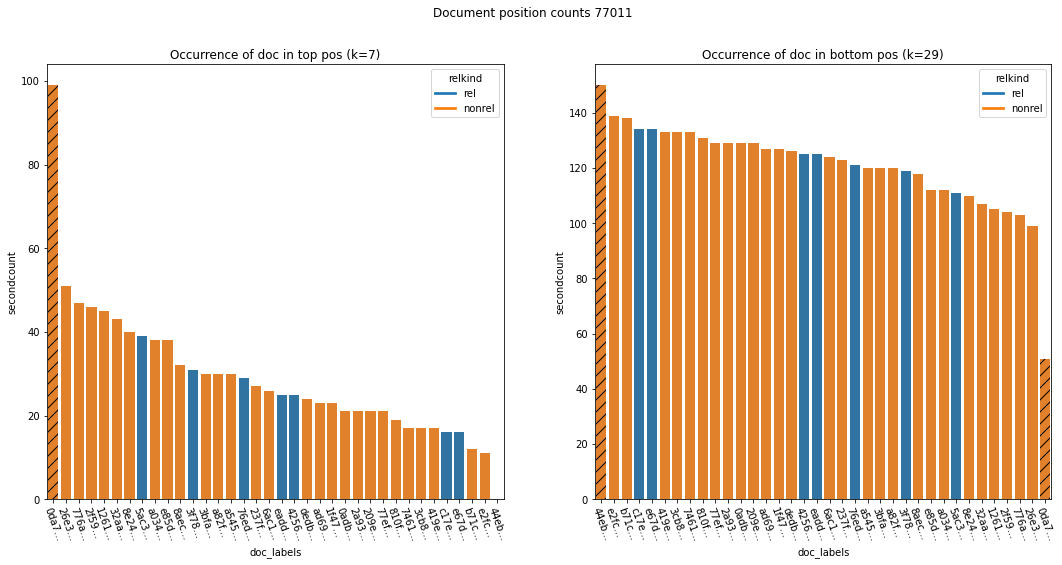

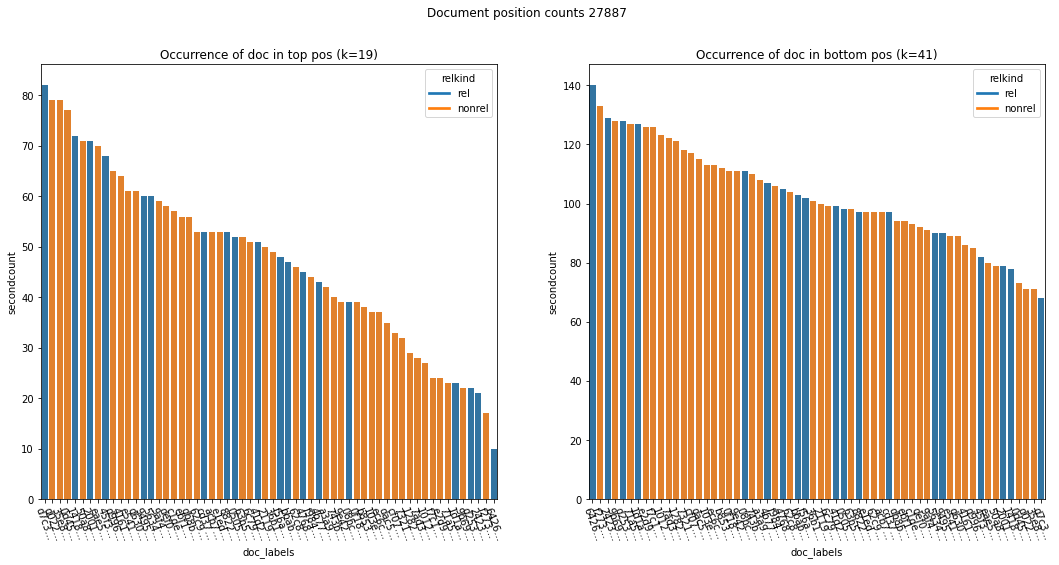

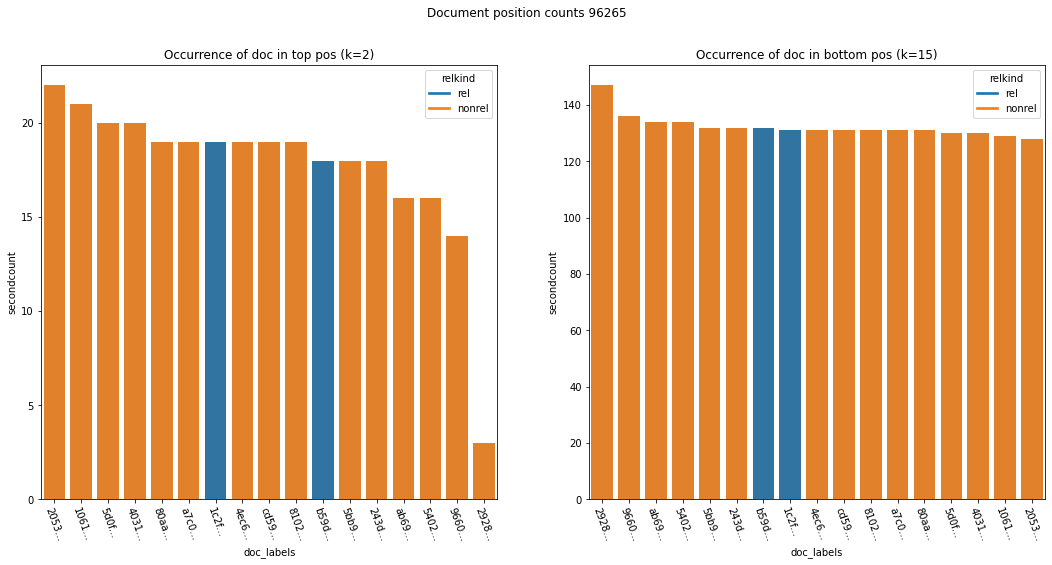

In [208]:
for q in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,no_author_ids=noauth_ids)

In [209]:
author_and_estrel = pd.merge(est_rel_meta,author_info,on='doc_id')
author_and_estrel.head()

,qid,doc_id,relevance,est_relevance,has_author
0,5438,3e19046c665867bbe557685da60738a40738010a,0,0.179419,True
1,5438,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0,0.145612,True
2,5438,ec13c3e7119191802e6f5783d297fe7a5a05293e,0,0.210751,True
3,5438,8fc928bb430d3f72ac876ca156042ad1860acacd,0,0.079591,True
4,5438,b2fdee22aa02477292b858fbafcb418932732bce,1,0.260175,True


In [ ]:
inpsect_qid = 30631

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['4f7cebcc071e129d41df4766d1aed1c55e236311',
                                                                      '943320b3c05a7aeace900e28d0c6d434804363b4',
                                                                      '8d442ea1c14504e6e5676d82e78e1330c354731f',
                                                                      '0e43caeb9d476264d307e8da0ad71ecc4d804ced']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The four documents with no author have some of the lowest estimated relevances for this query. This may explain why some of them are ranked quite lowly. But it's still strange that one of them spikes?

For query 30631 there is one authorless doc that spikes, and three that don't. These three have a lower est rel than the spiking document, but not *much* lower, aside from one. The three that spike in fact barely appear in the ranking at all...

###### qid = 111469

In [ ]:
inpsect_qid = 111469

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['e60af557a1bbfd9b2adee8a3c090d27faab86632',
                                                                      '25c40e796680cdea53578dfad8c7bdbae7ee56a5']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 71096

In [ ]:
inpsect_qid = 71096

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['6afc97668839a439e6858691ada76c9ddf798c2a',
                                                                      '30a698ba5648295c91f00545326931eaf07b00be']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 96265

In [ ]:
inpsect_qid = 96265

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 15898

In [ ]:
inpsect_qid = 15395

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

Document af94eb52e8f7a52b1800414646ab729f34da9191 has a reasonably high estimated relevance but nevertheless never occurs in a top position.

**Hypothesis**: Is this because it has multiple authors? And thus is doubly penalized?
--> no

In [ ]:
adf[adf['id'] == 'af94eb52e8f7a52b1800414646ab729f34da9191']

In [ ]:
pd.merge(author_and_estrel[author_and_estrel.qid == inpsect_qid],adf.rename({'id':'doc_id'},axis=1),on='doc_id',how='left')

Some documents have author in the index but not in the merged annotations file? Has influence on the grouping?


In [ ]:
noauth_ids

Some remarks: 
- Many of the bottom queries indeed have a non-relevant no-author item in a top position, and no relevant no-author items.
- Out of the top queries, two have a relevant no-author item in a top position, and no non-relevant no-author items.

    
- there are still numerous rankings with (top?) documents missing from the ranking, why is that?

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [ ]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

In [ ]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

In [ ]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

In [ ]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [ ]:
no_author = find_docs_without_author(reldf)

Out of the items in the sample file, 4605 are also in the index.

26 items have no author in the index

In [ ]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

In [ ]:
topmerge[(topmerge.has_author == False)]

In [ ]:
botmerge[(botmerge.has_author == False)]

In [ ]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

In [ ]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [ ]:
botmerge[(botmerge.has_author == False)]

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [ ]:
topmerge.head(10)

In [ ]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

In [ ]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

In [ ]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

There are 58 queries for which one or more documents don't have an author.

In [ ]:
all_qs_with_no_auth.qid.unique()

In [ ]:
all_qs_with_no_auth['index'].unique().mean()

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

In [ ]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

In [ ]:
data.head()

In [ ]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

In [ ]:
crossdata.head().columns

In [ ]:
crossdata[(0,False)].to_list()

In [ ]:
crossdata.head().index.to_list()

In [ ]:
np.arange(len(rel_has_author)*2,step=2)

In [ ]:
rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

In [ ]:
crossdata.index.to_list()[:10]

In [ ]:
def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [ ]:
plot_has_authors(crossdata)

In [ ]:
plot_has_authors(crossdata,asc=False)

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


In [ ]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 


In [ ]:
est_rel_meta.describe()

In [ ]:
reldf.describe()

In [ ]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

In [ ]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

In [ ]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

# Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.